In [1]:
import torch

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

/home/mk/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from dataset import DwgDataset
dwg_dataset = DwgDataset('test_dataset_cluster_labeled.pickle', batch_size = 2)
dim_features = dwg_dataset.entities.dim_features
ent_features = dwg_dataset.entities.ent_features

In [3]:
from model import DimTransformer
model = DimTransformer(ent_features=ent_features, dim_features=dim_features, hidden_size=1024, enforced_device=device)
model.to(device)


# https://pytorch.org/tutorials/beginner/saving_loading_models.html
model.load_state_dict(torch.load('DimTransformerTrained.model', map_location=device))

model.eval()

DimTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=16, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_

In [4]:
import drawSvg as draw
from plot_graphics import draw_sample

tensor([0.6523, 0.4353, 0.7744, 0.4334], grad_fn=<SelectBackward>)
entities: 75


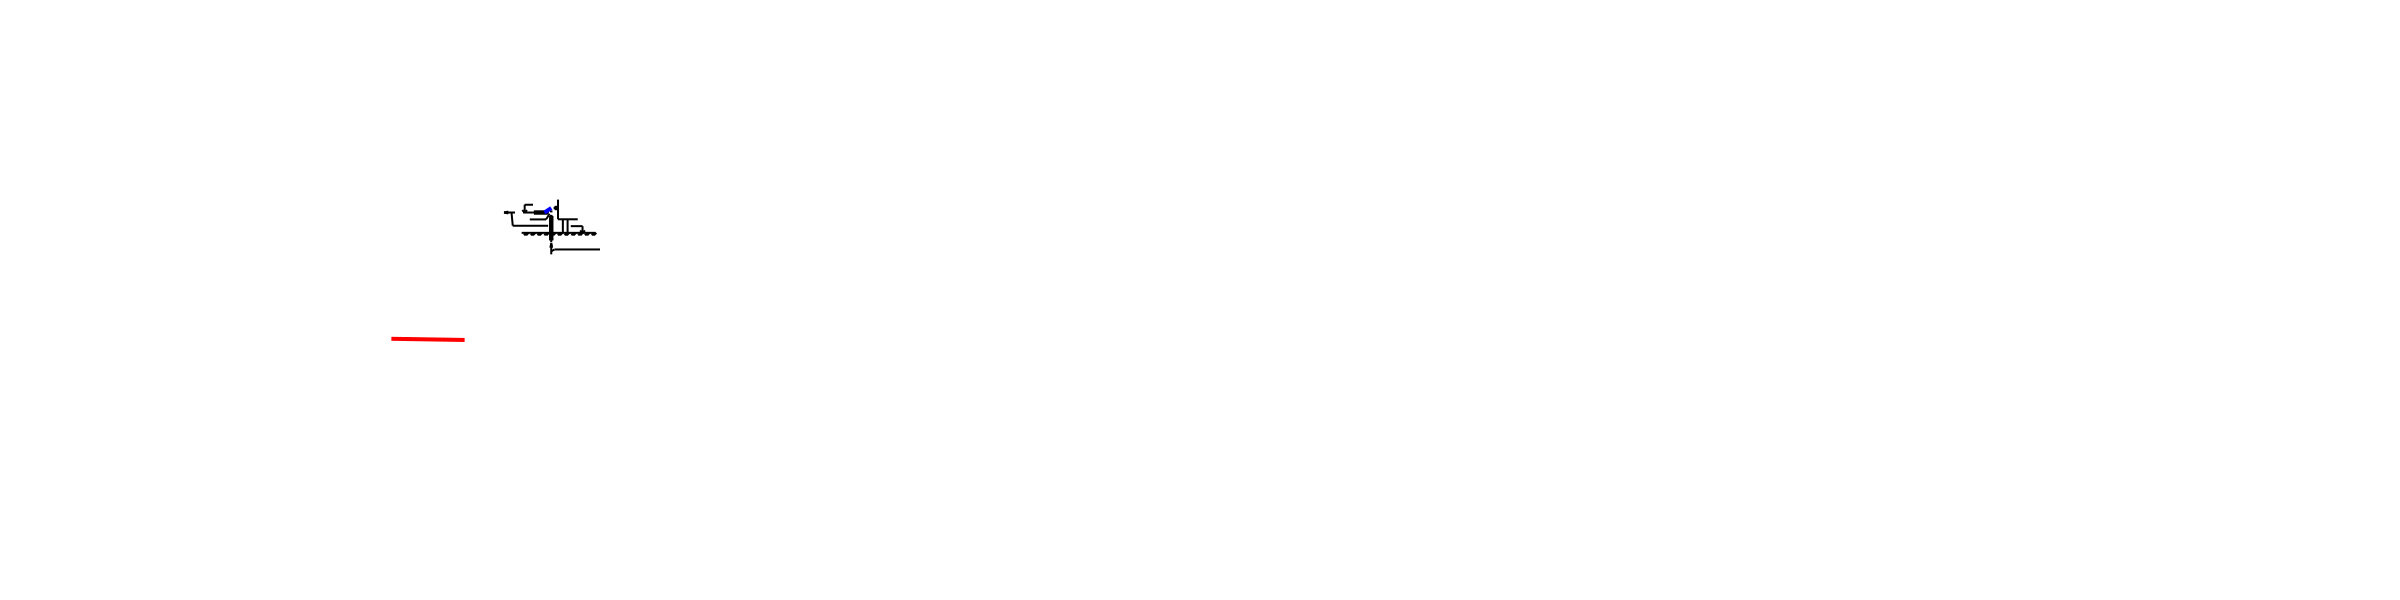

tensor([0.7026, 0.7470, 0.5464, 0.7634], grad_fn=<SelectBackward>)
entities: 151


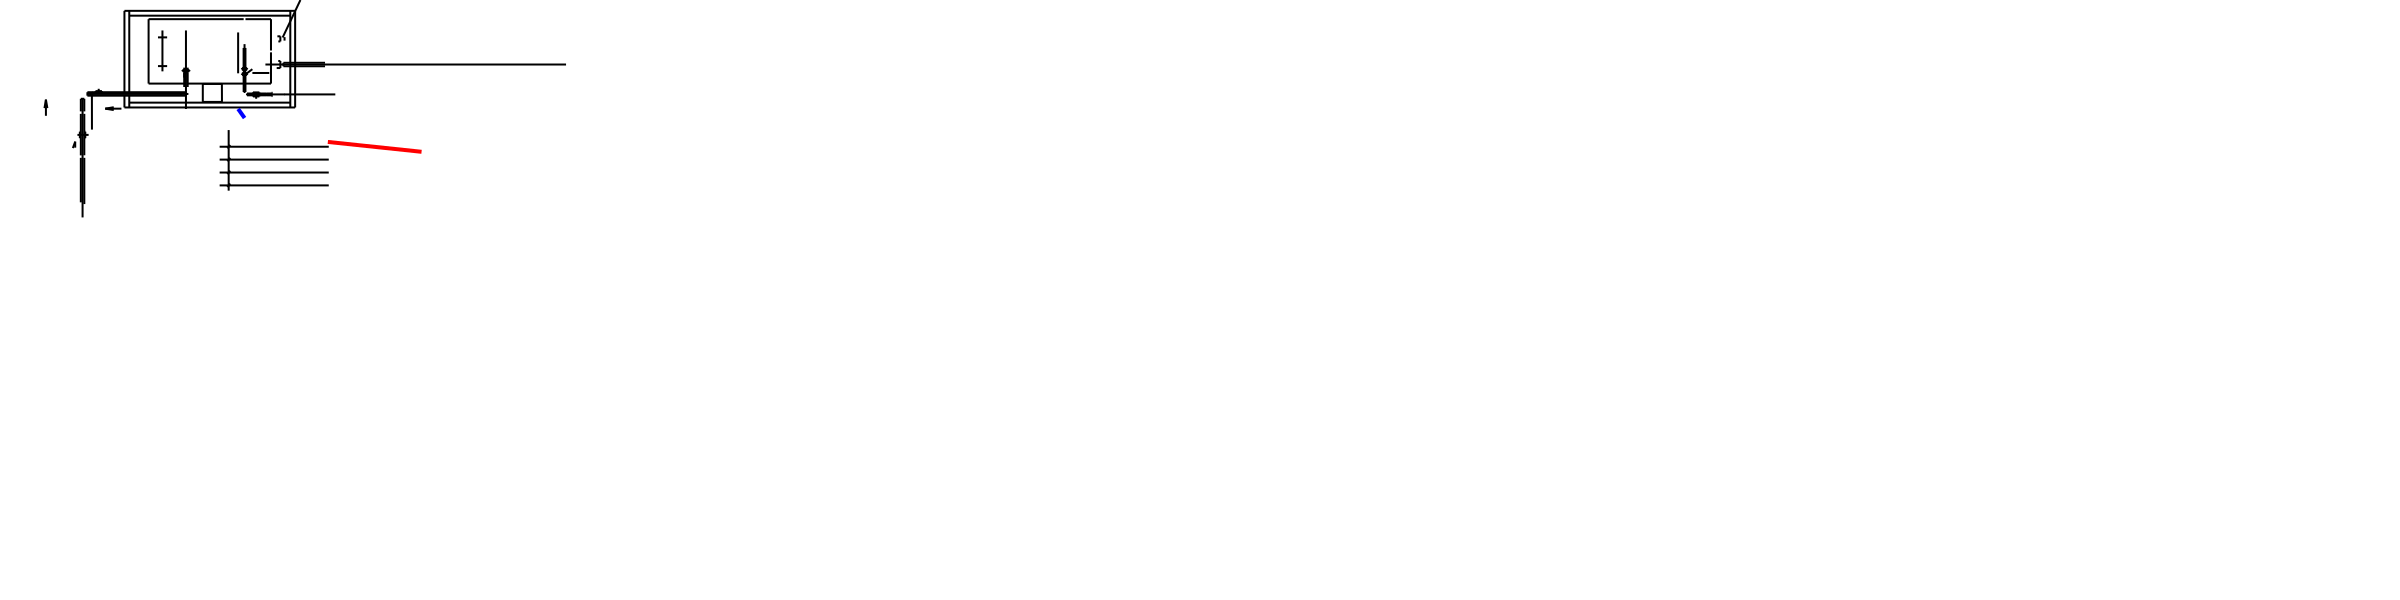

tensor([ 0.6087,  1.0027, -0.0396,  1.2599], grad_fn=<SelectBackward>)
entities: 4391


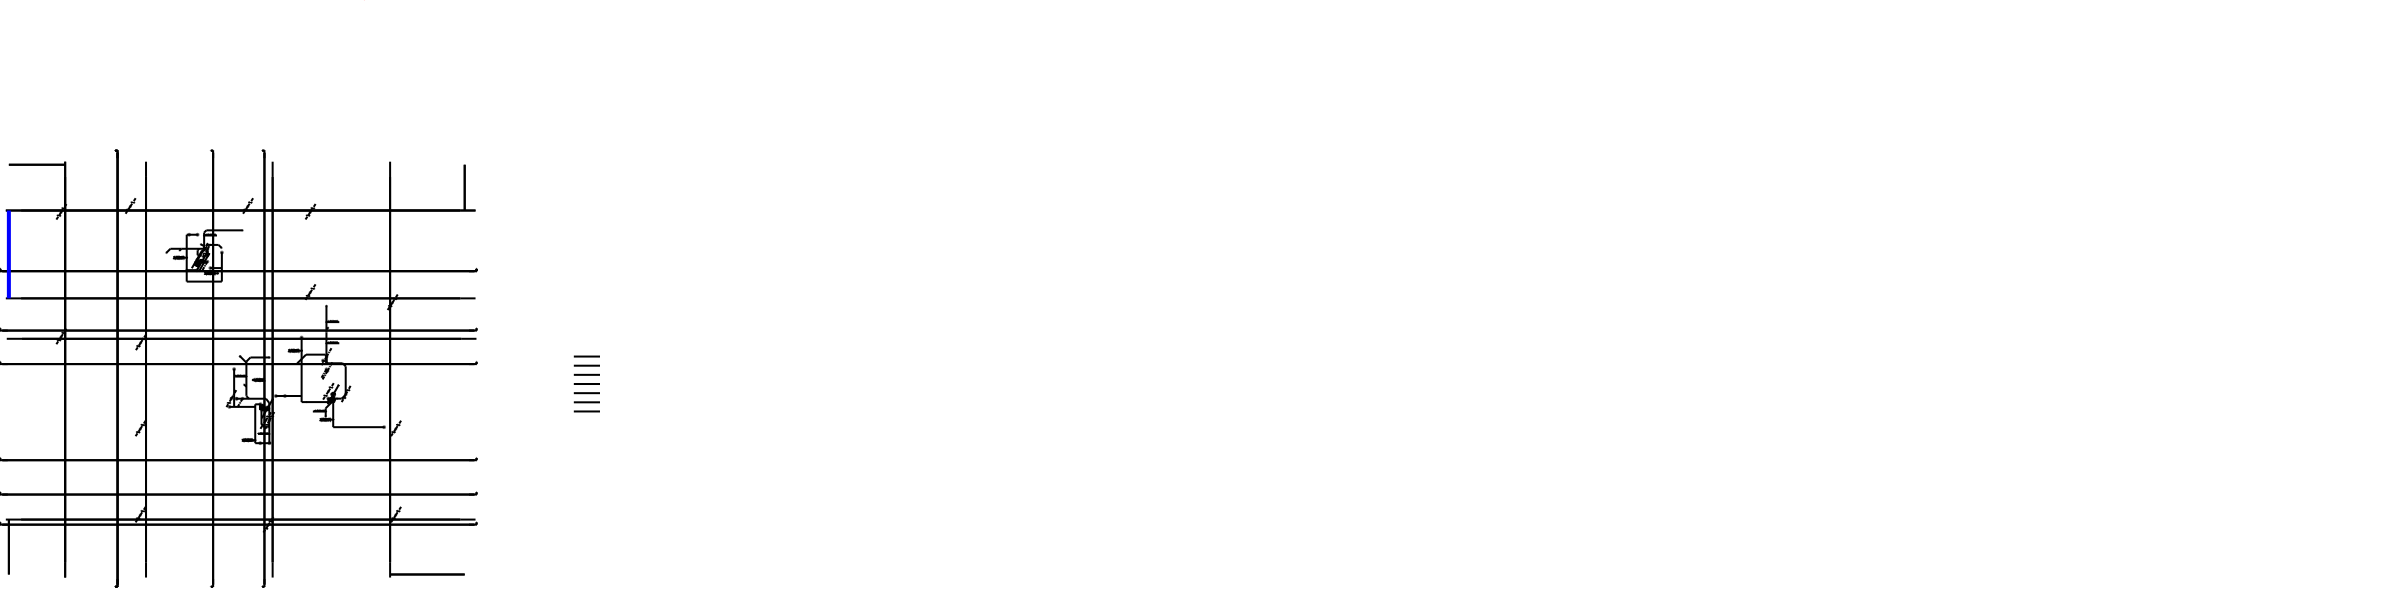

tensor([0.6344, 0.3719, 0.8086, 0.3575], grad_fn=<SelectBackward>)
entities: 468


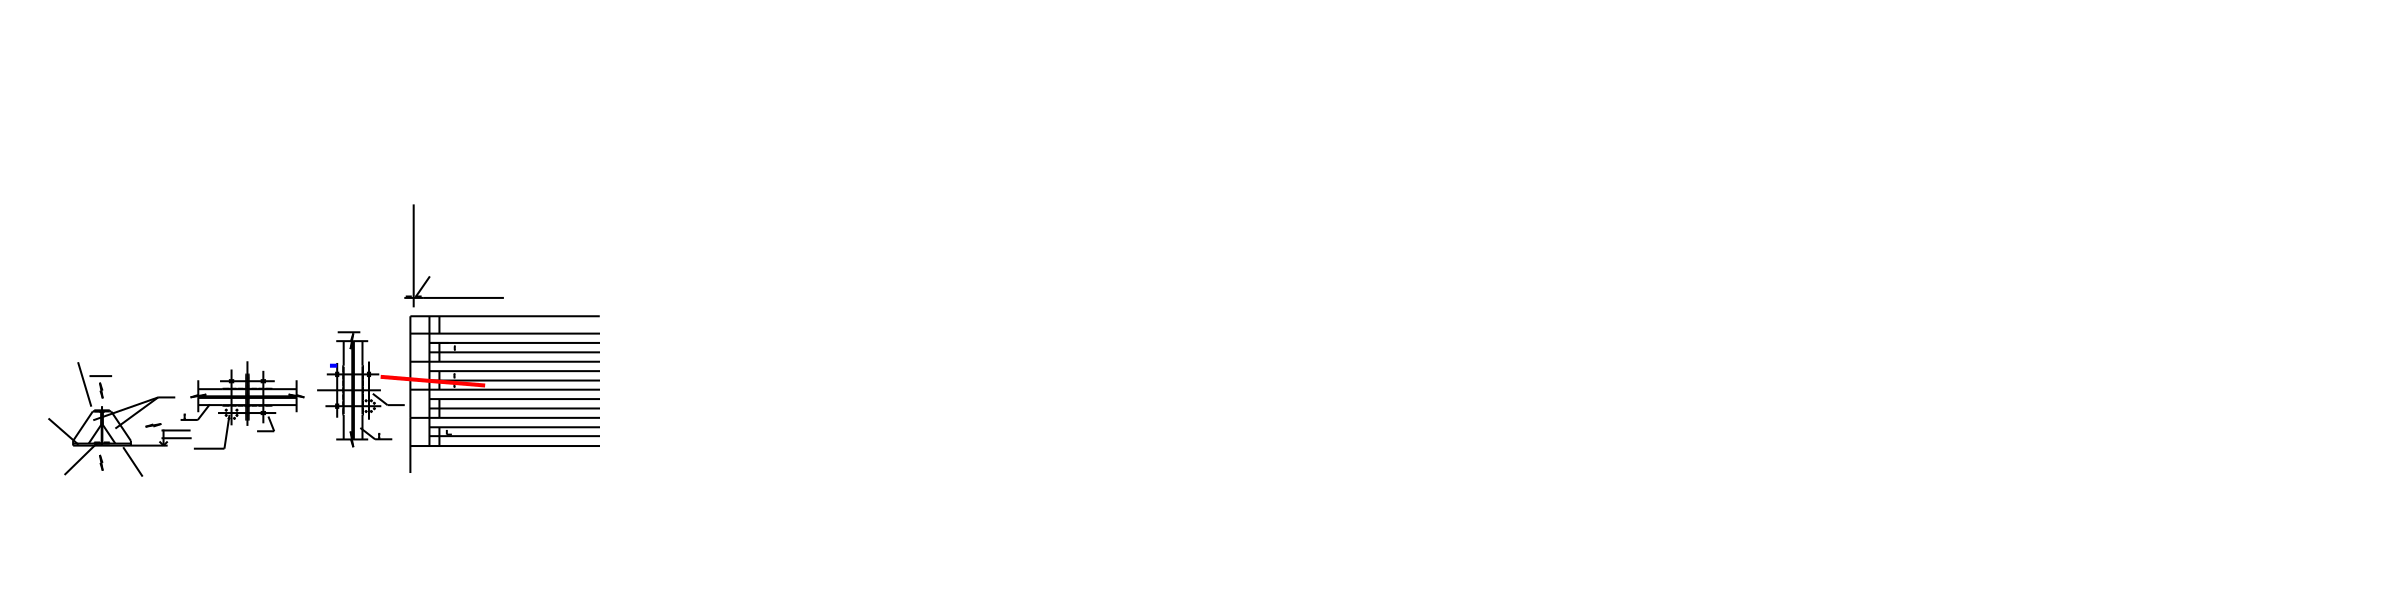

tensor([0.6956, 0.6701, 0.6146, 0.6812], grad_fn=<SelectBackward>)
entities: 1014


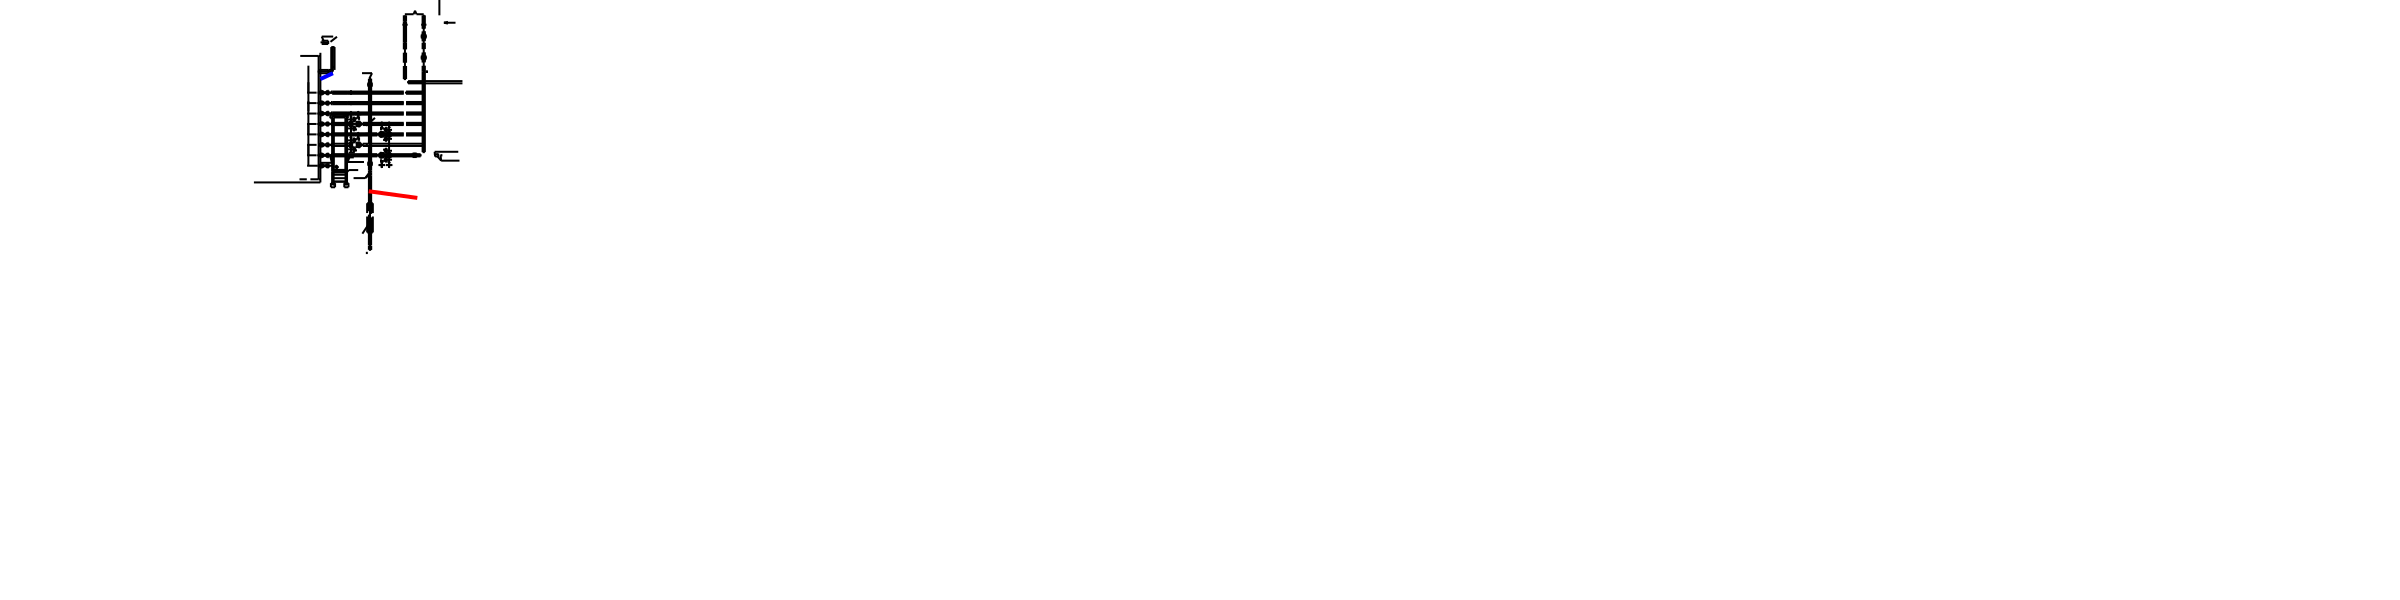

tensor([0.1140, 0.0104, 0.0621, 0.0094], grad_fn=<SelectBackward>)
entities: 28


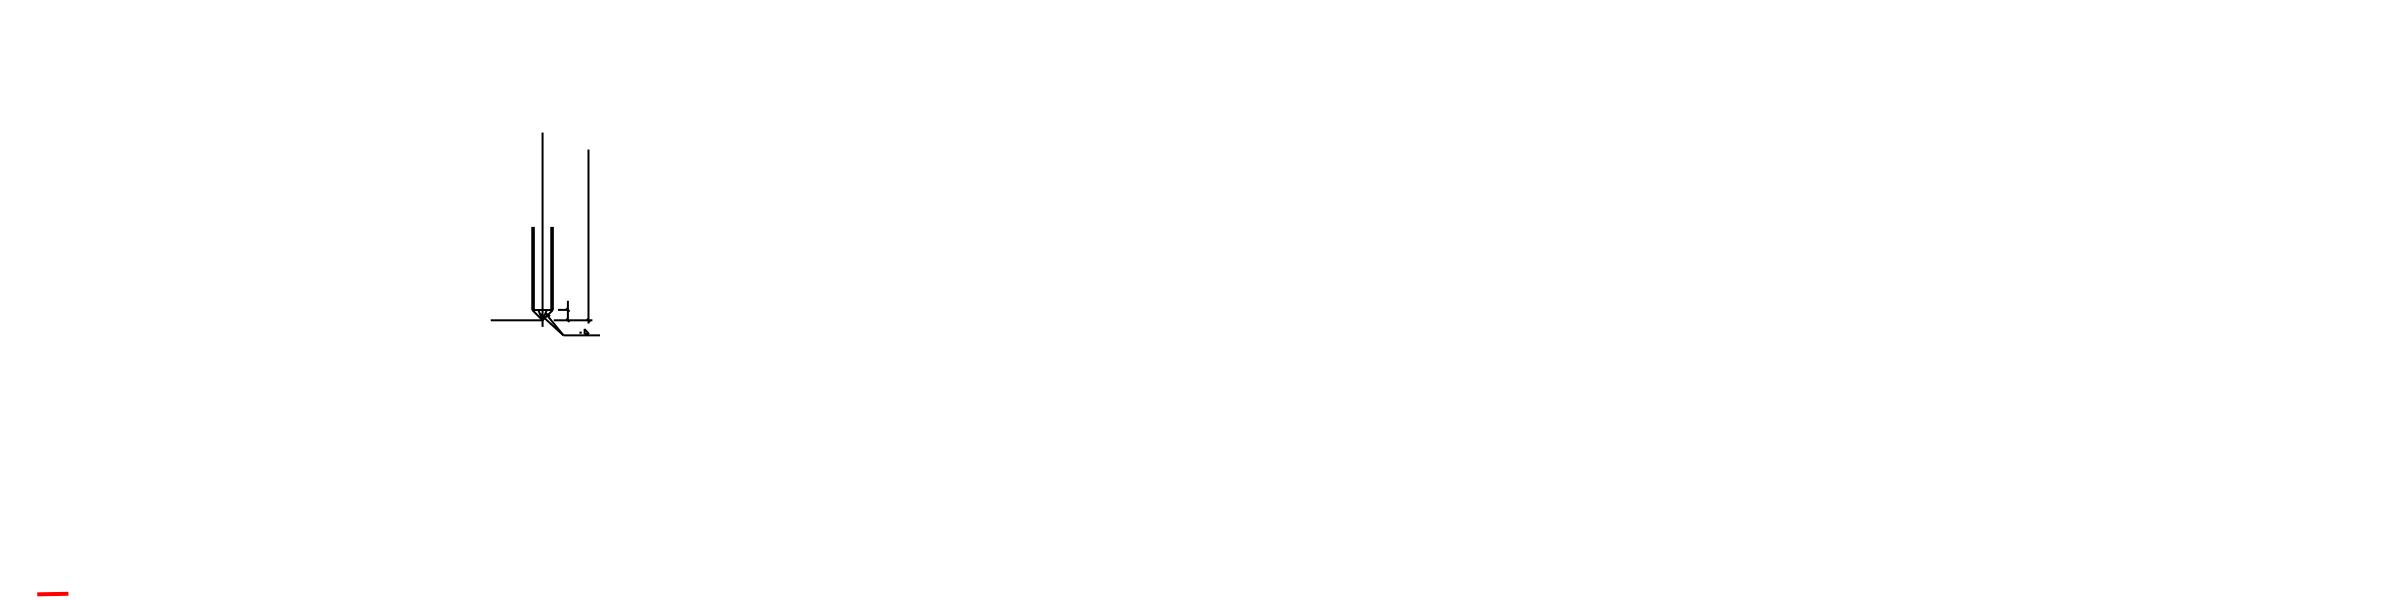

tensor([0.5512, 0.1293, 0.8859, 0.1116], grad_fn=<SelectBackward>)
entities: 3051


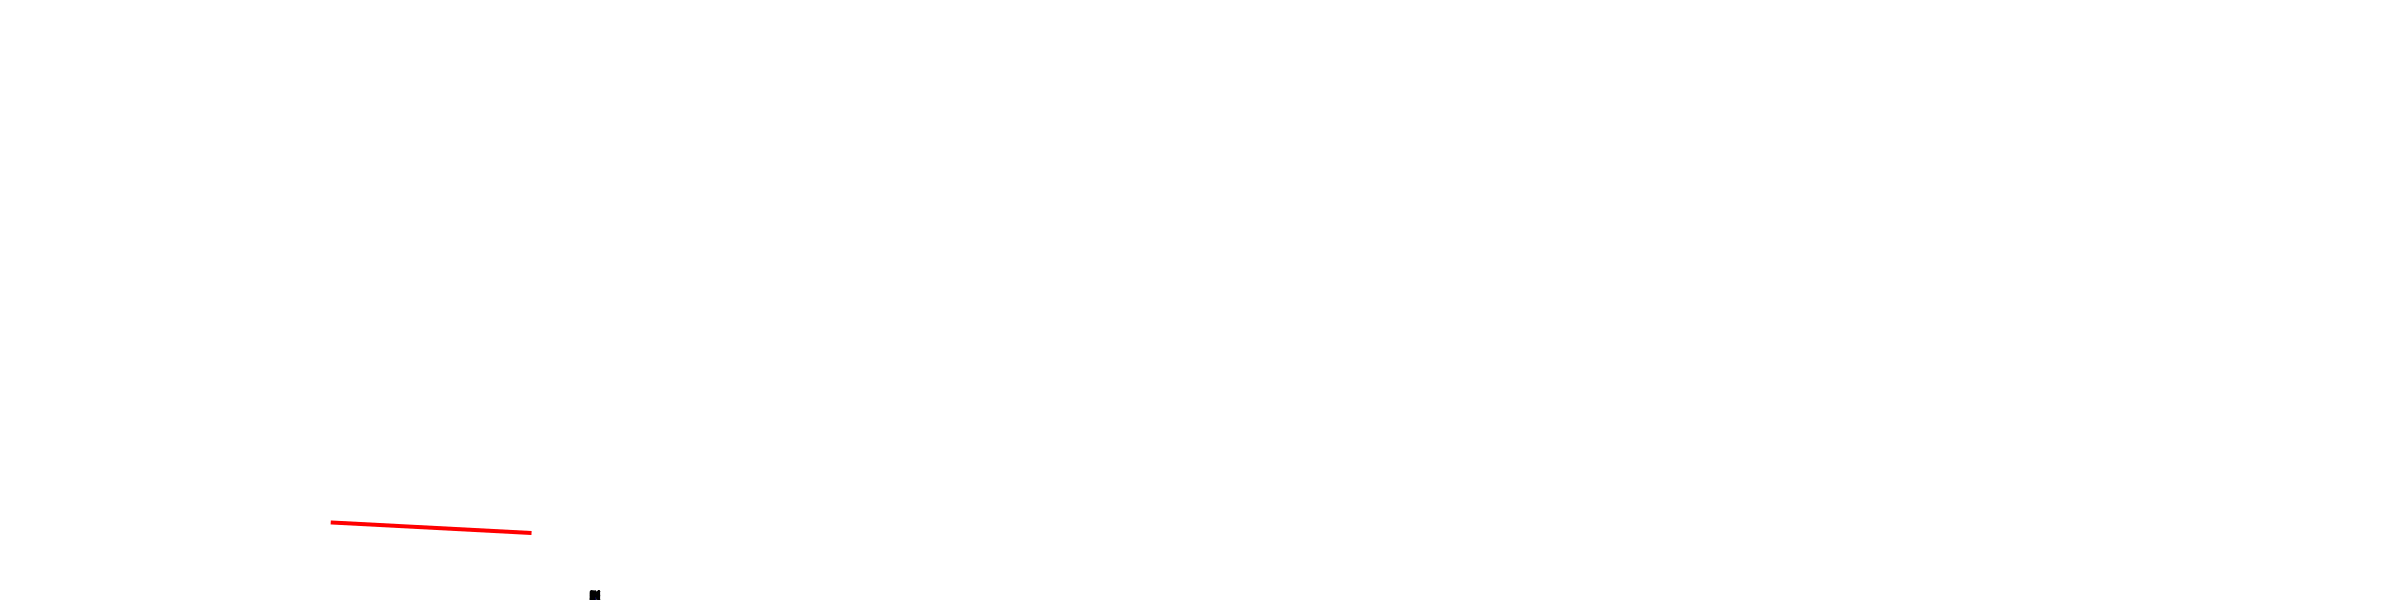

tensor([0.6035, 0.2740, 0.8498, 0.2495], grad_fn=<SelectBackward>)
entities: 468


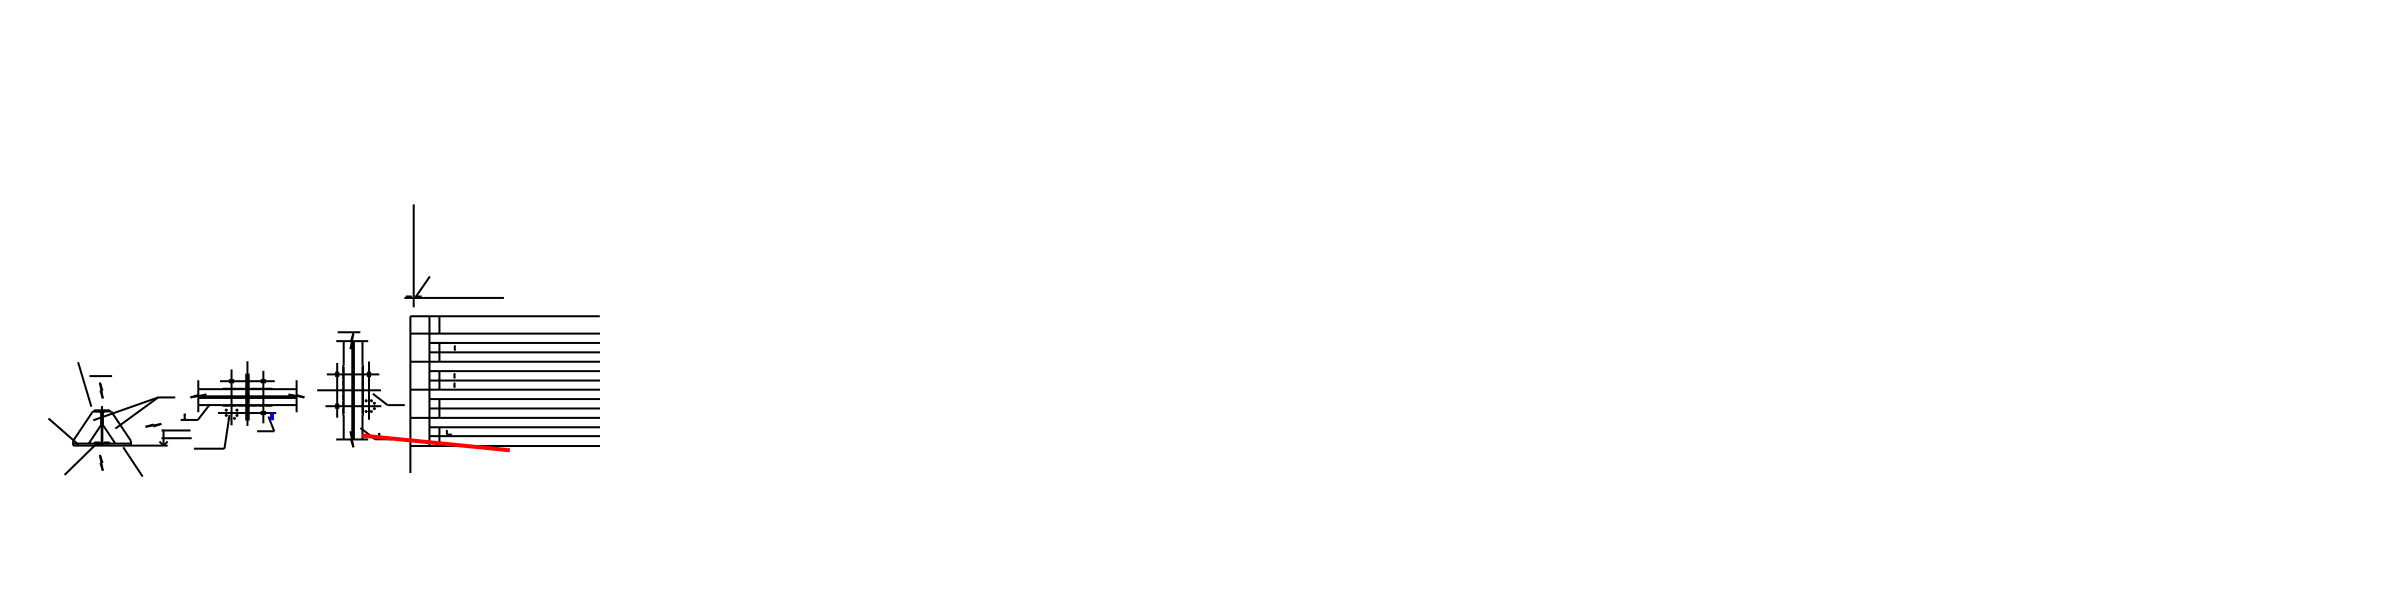

tensor([0.1141, 0.0454, 0.0253, 0.0447], grad_fn=<SelectBackward>)
entities: 56


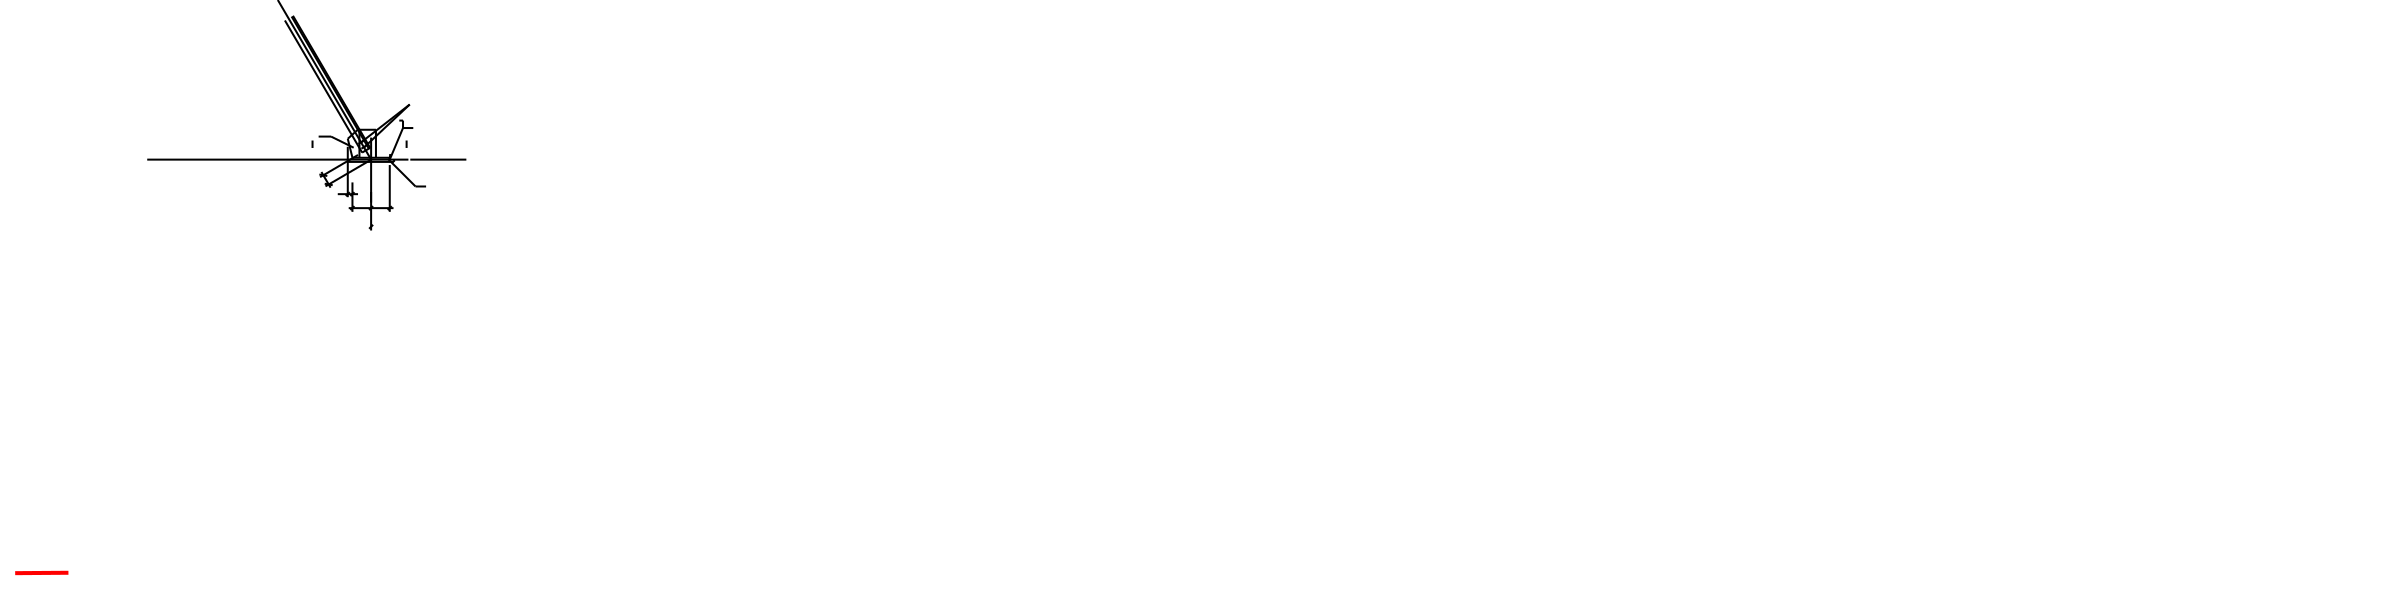

tensor([0.6968, 0.6822, 0.6057, 0.6909], grad_fn=<SelectBackward>)
entities: 33


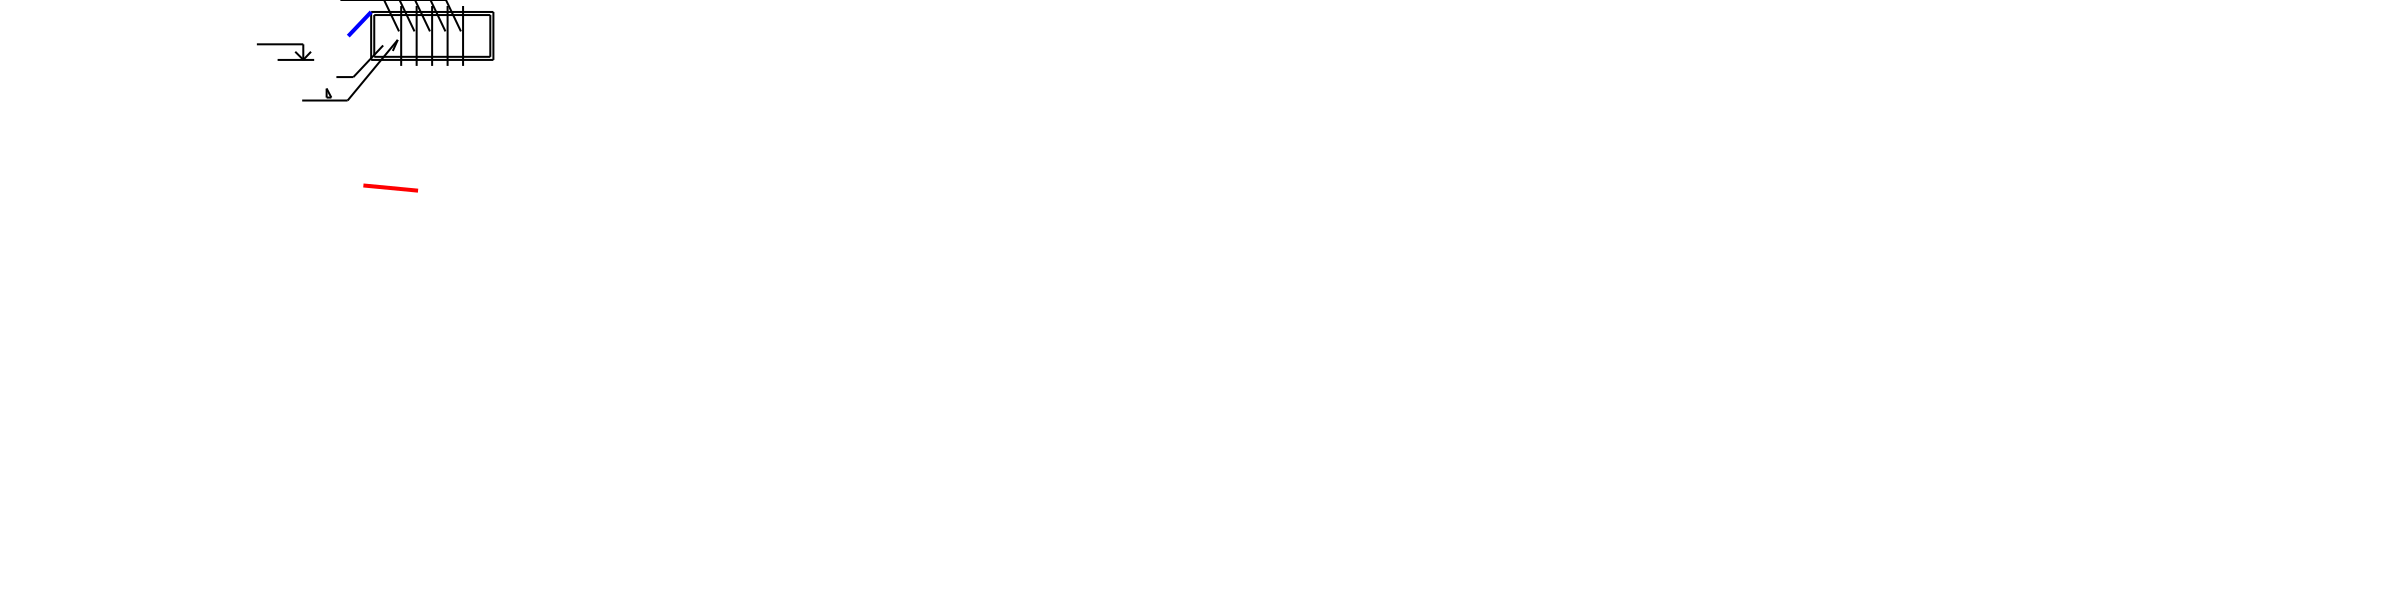

tensor([0.6437, 0.4023, 0.7920, 0.3977], grad_fn=<SelectBackward>)
entities: 1180


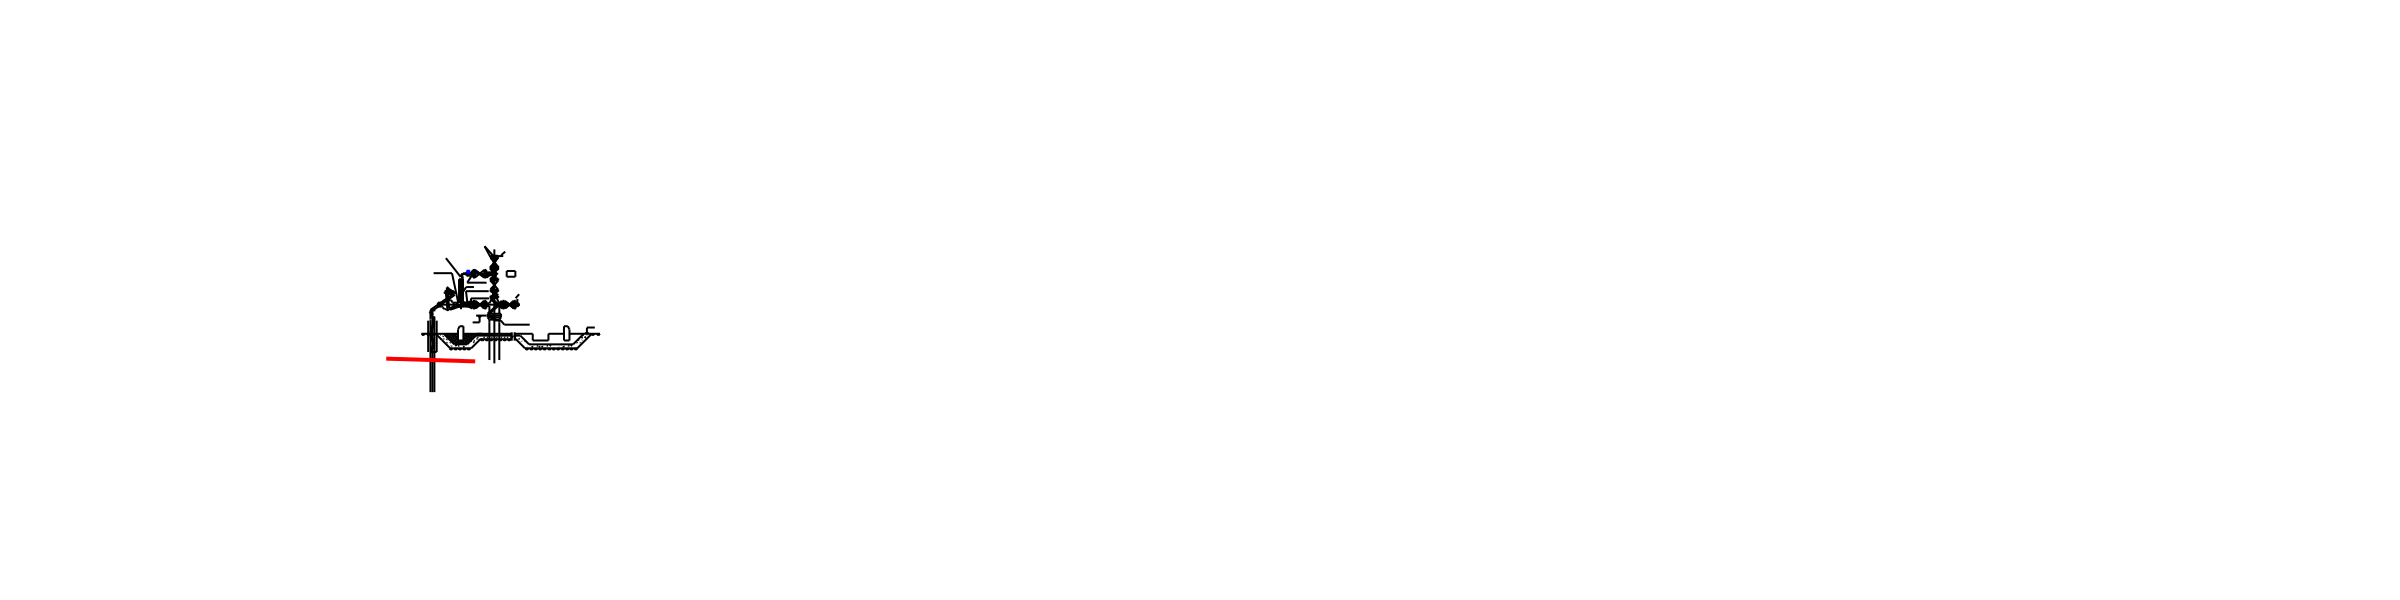

tensor([ 0.1149,  0.0731, -0.0026,  0.0735], grad_fn=<SelectBackward>)
entities: 16


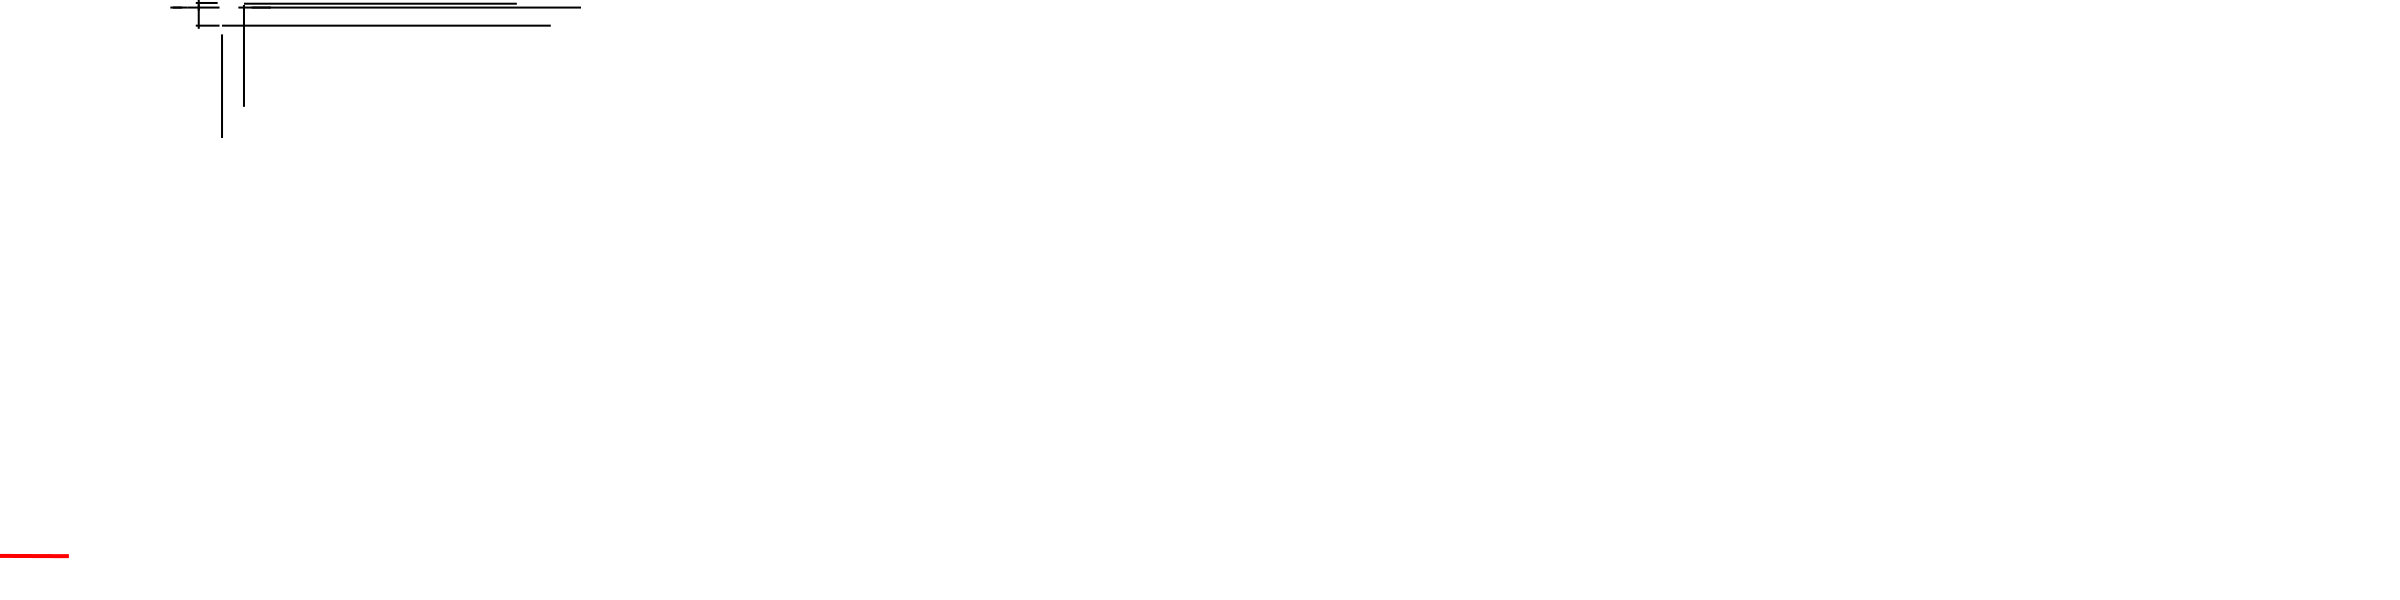

tensor([0.6422, 0.3970, 0.7949, 0.3908], grad_fn=<SelectBackward>)
entities: 59


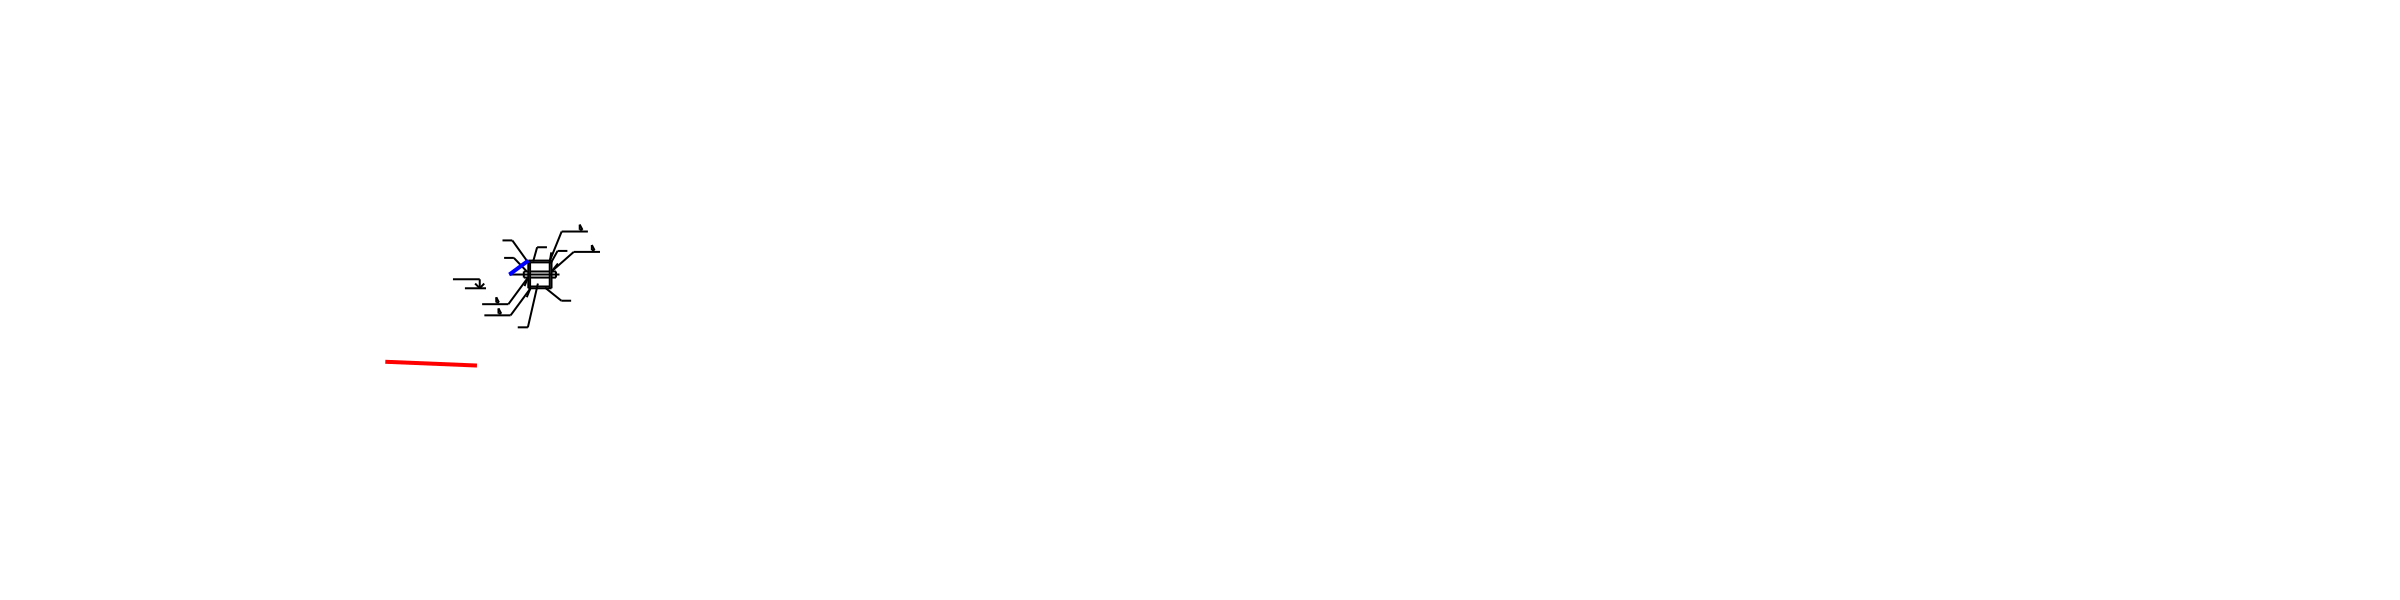

tensor([0.6333, 0.3655, 0.8104, 0.3565], grad_fn=<SelectBackward>)
entities: 1180


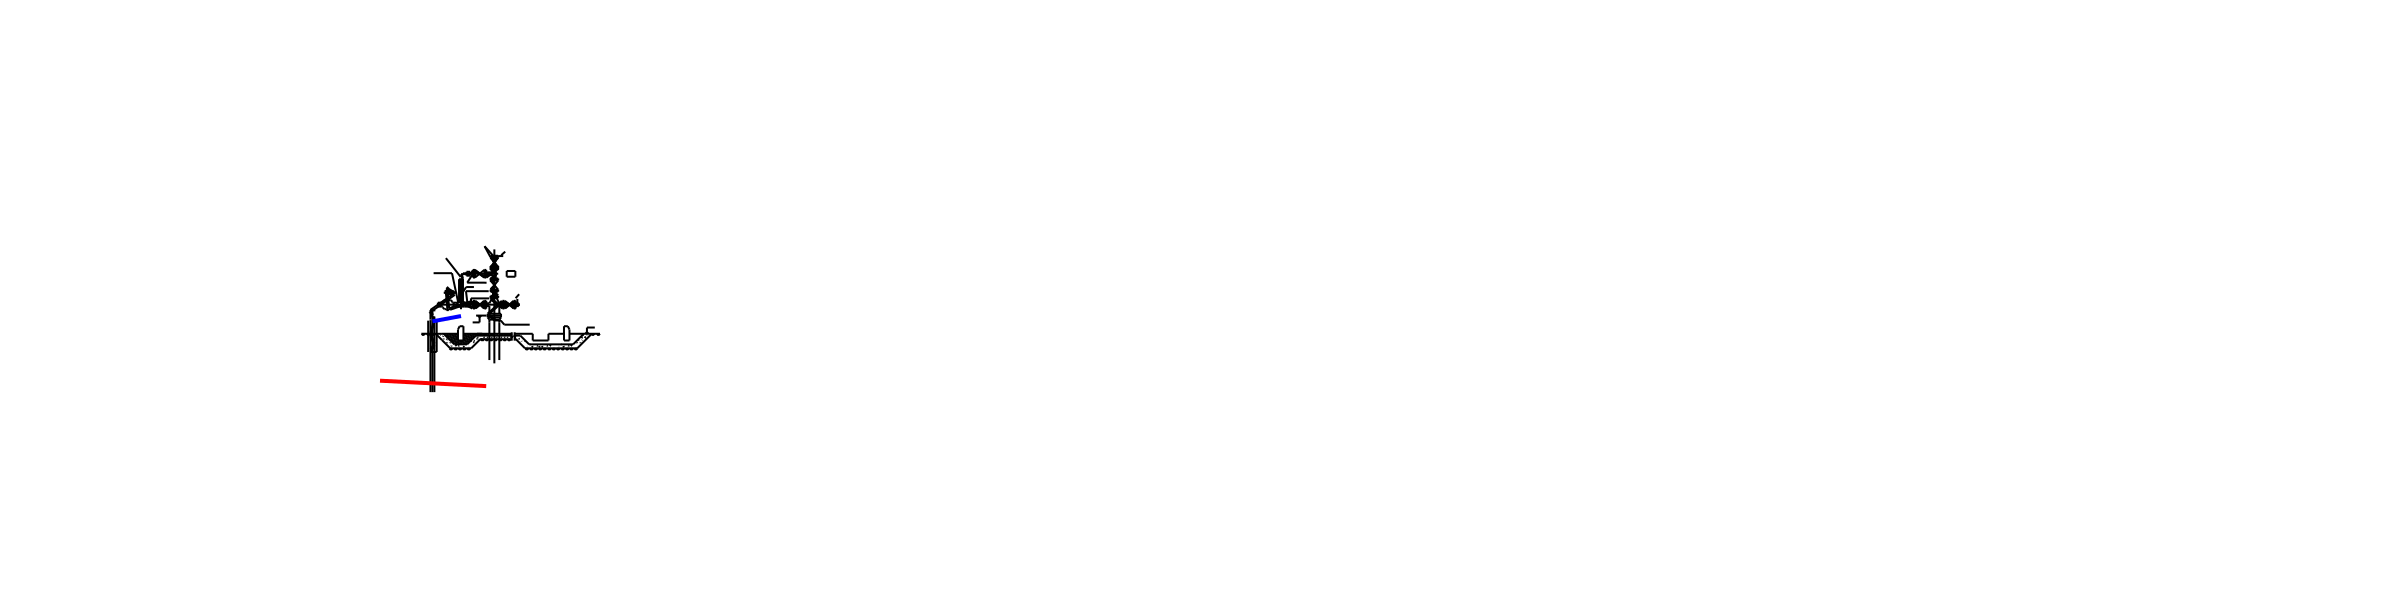

tensor([0.7049, 0.8407, 0.4467, 0.8701], grad_fn=<SelectBackward>)
entities: 151


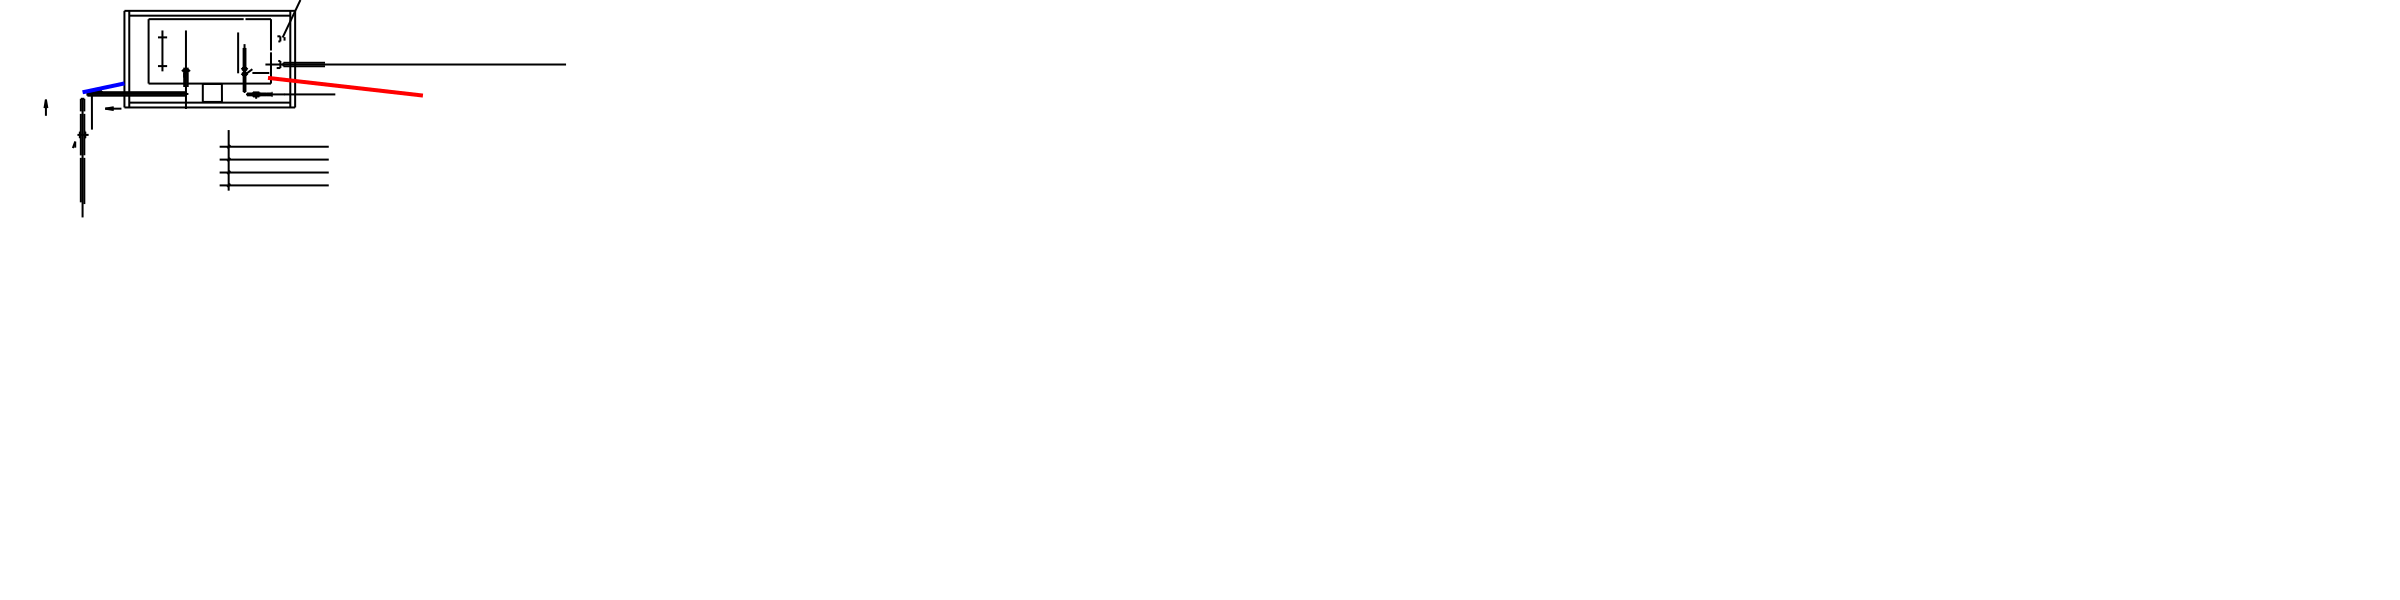

tensor([0.1144, 0.0603, 0.0102, 0.0599], grad_fn=<SelectBackward>)
entities: 151


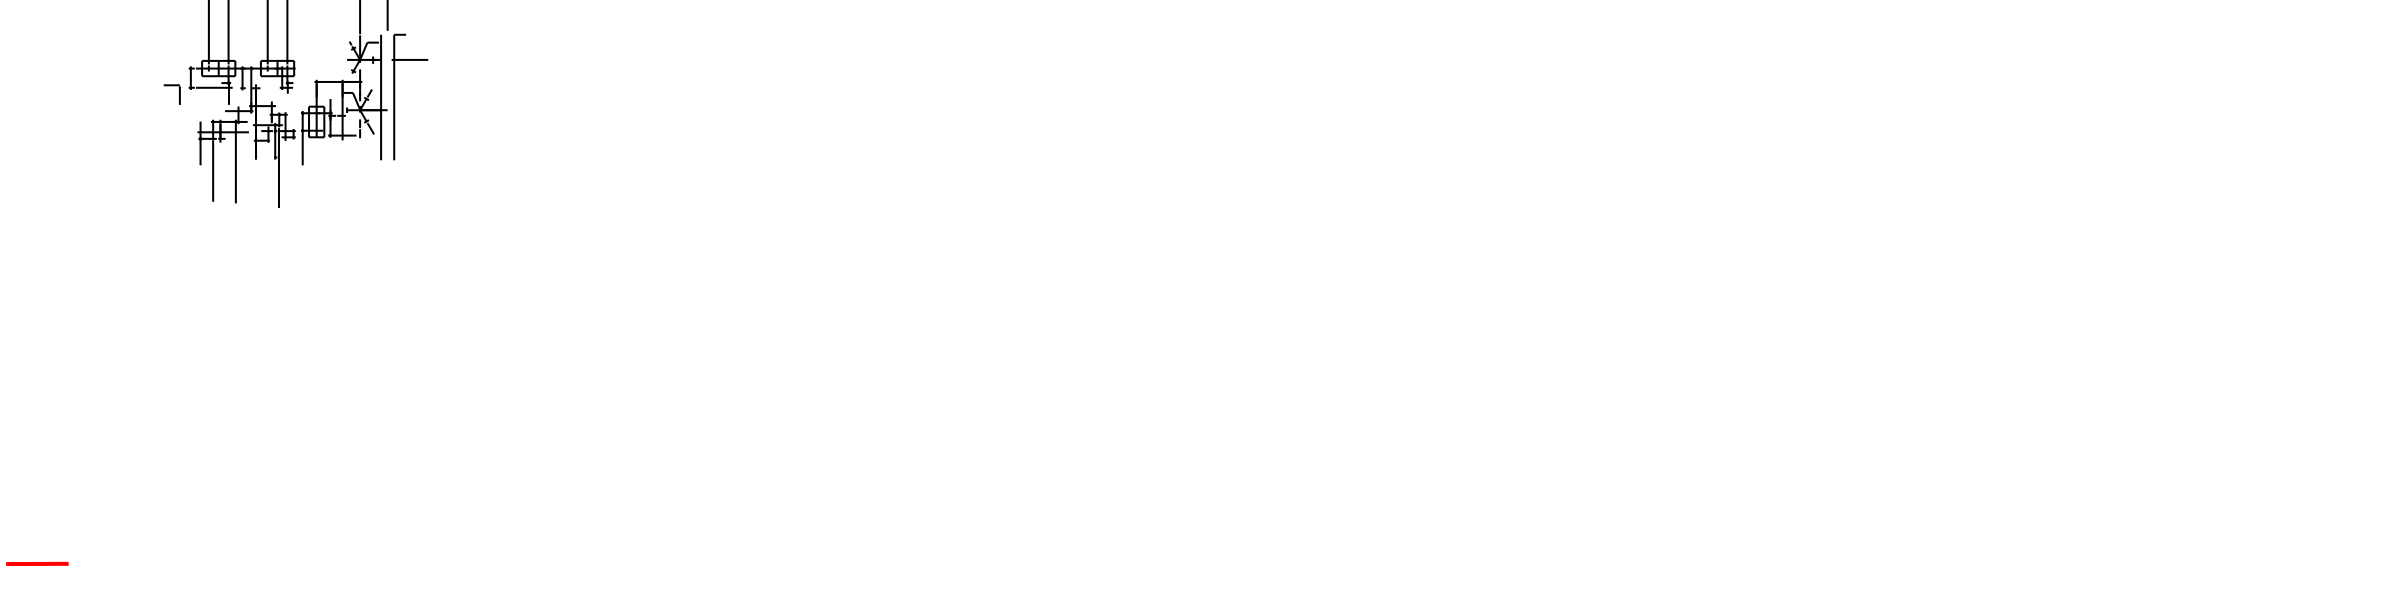

tensor([ 0.1150,  0.0769, -0.0064,  0.0776], grad_fn=<SelectBackward>)
entities: 17


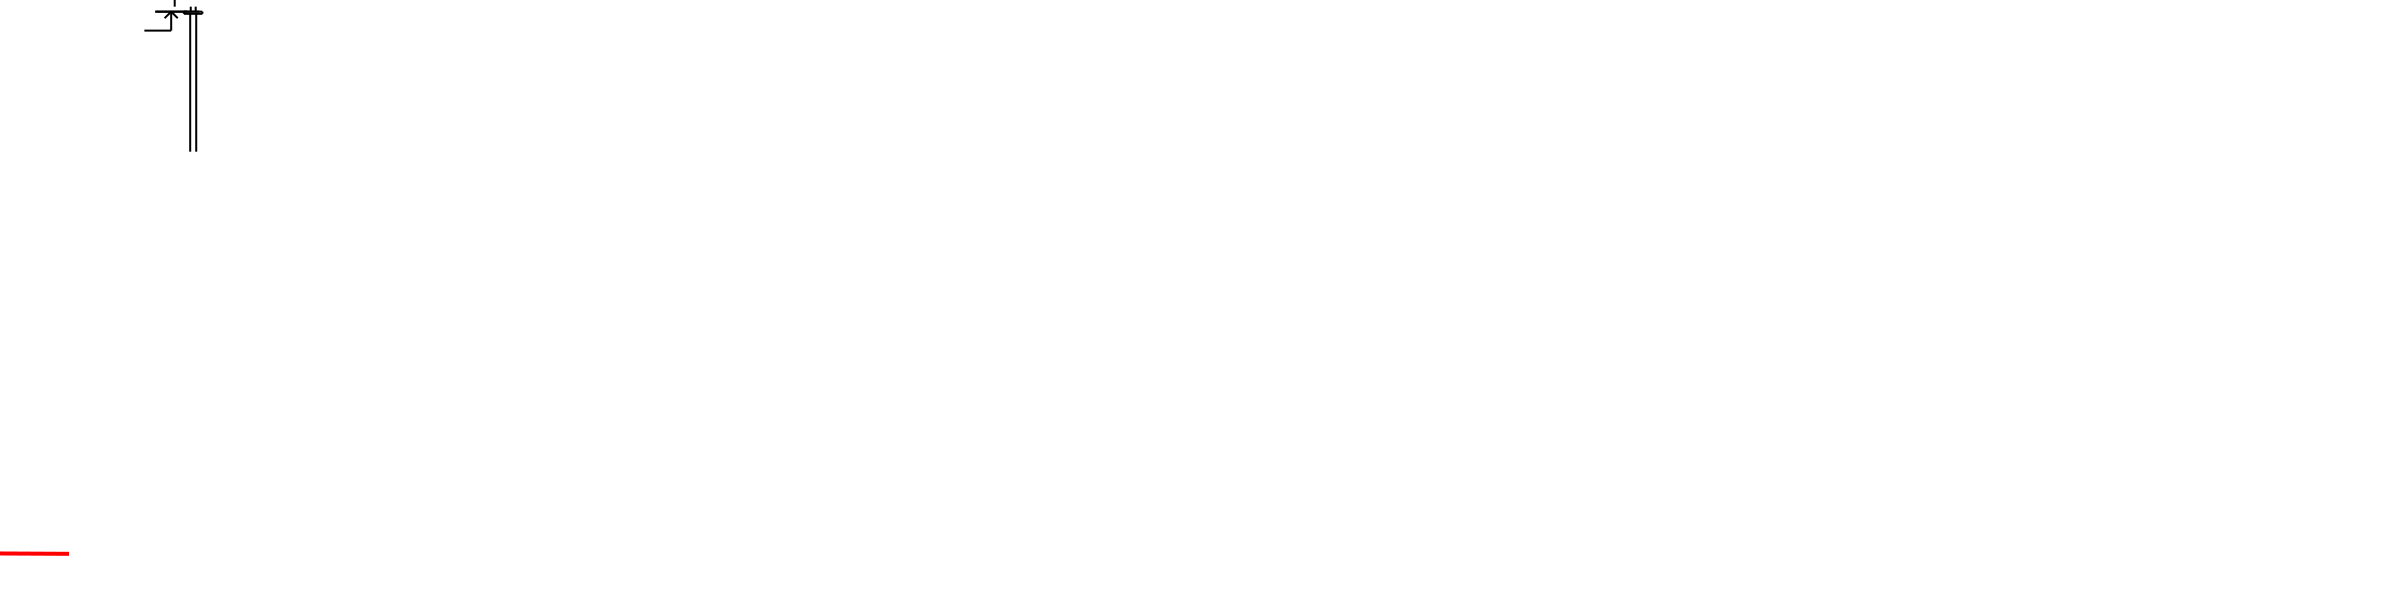

tensor([0.6864, 0.6060, 0.6665, 0.6083], grad_fn=<SelectBackward>)
entities: 33


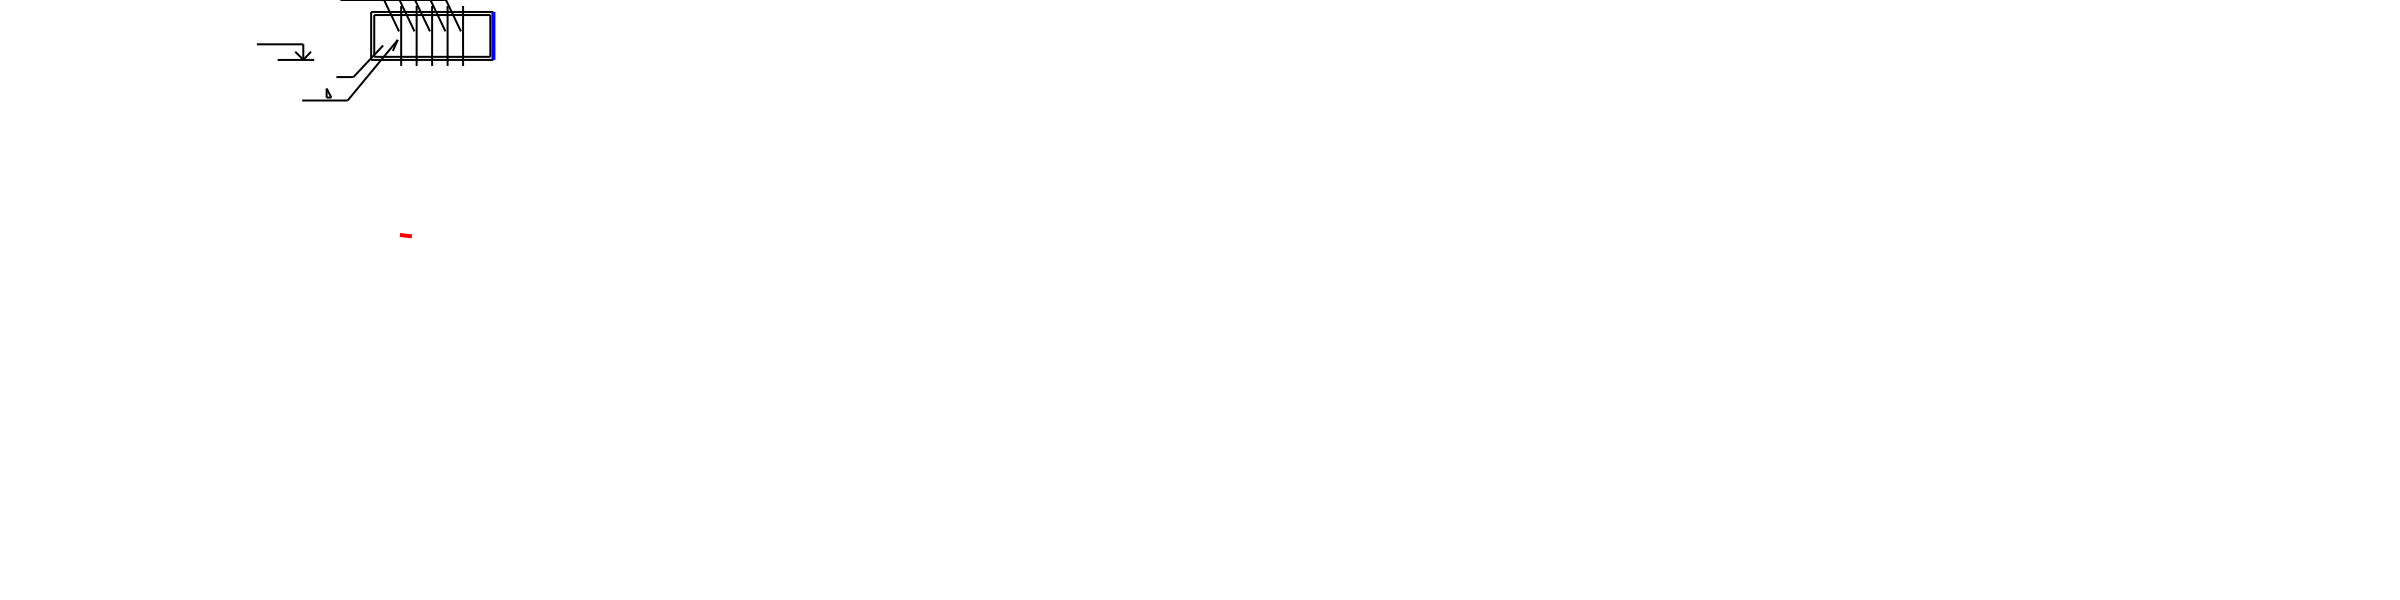

tensor([0.6608, 0.4772, 0.7544, 0.4632], grad_fn=<SelectBackward>)
entities: 26


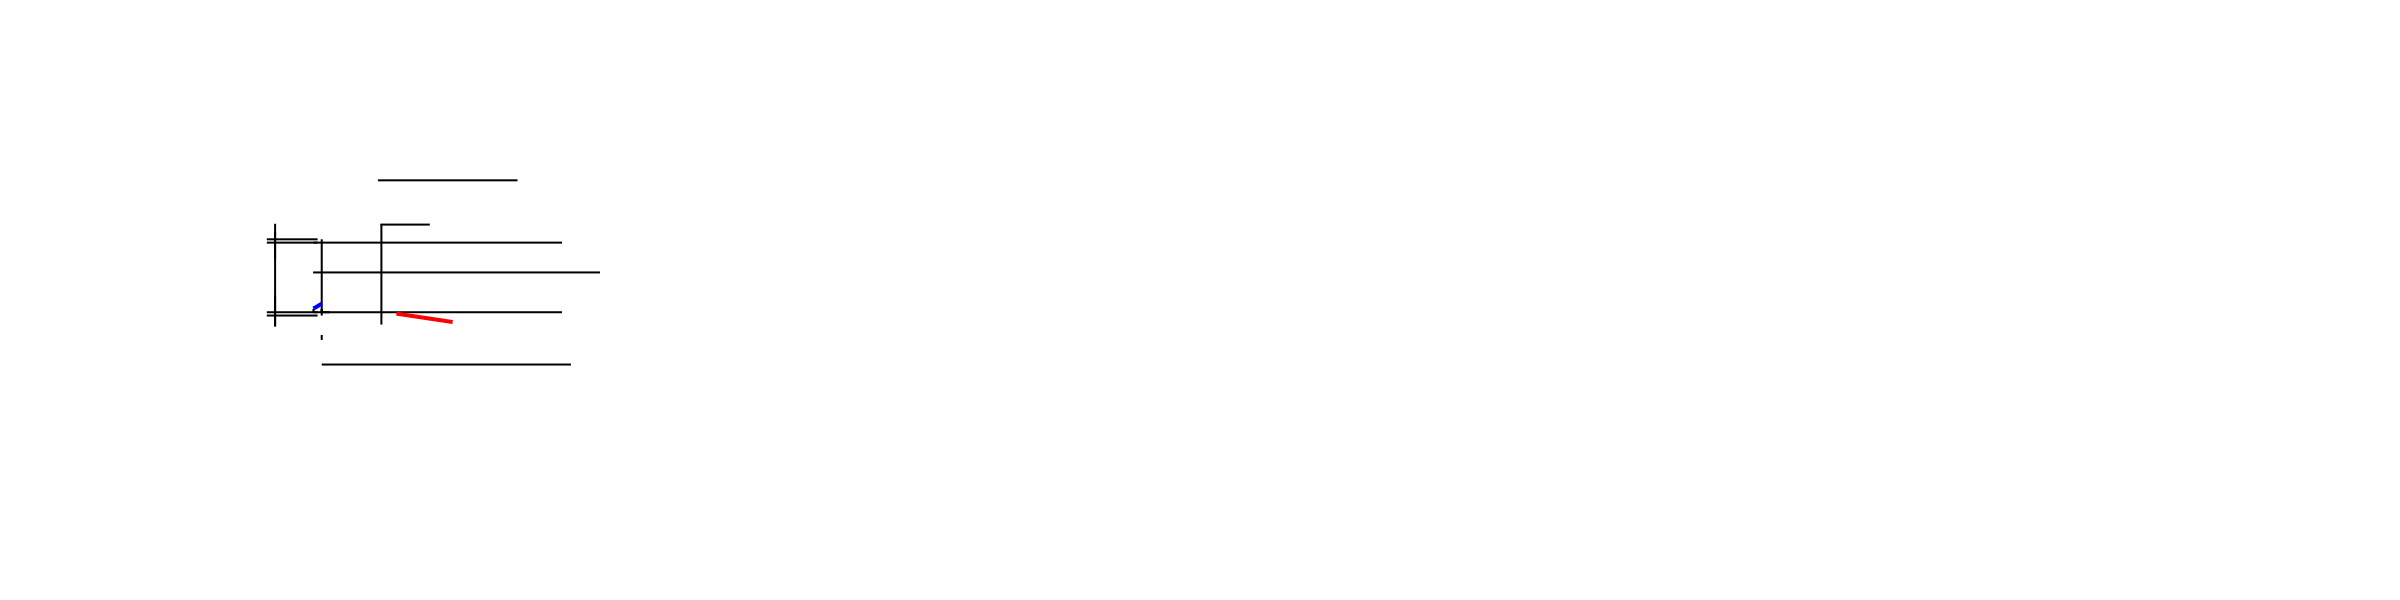

tensor([0.6208, 0.3726, 0.8286, 0.2537], grad_fn=<SelectBackward>)
entities: 1027


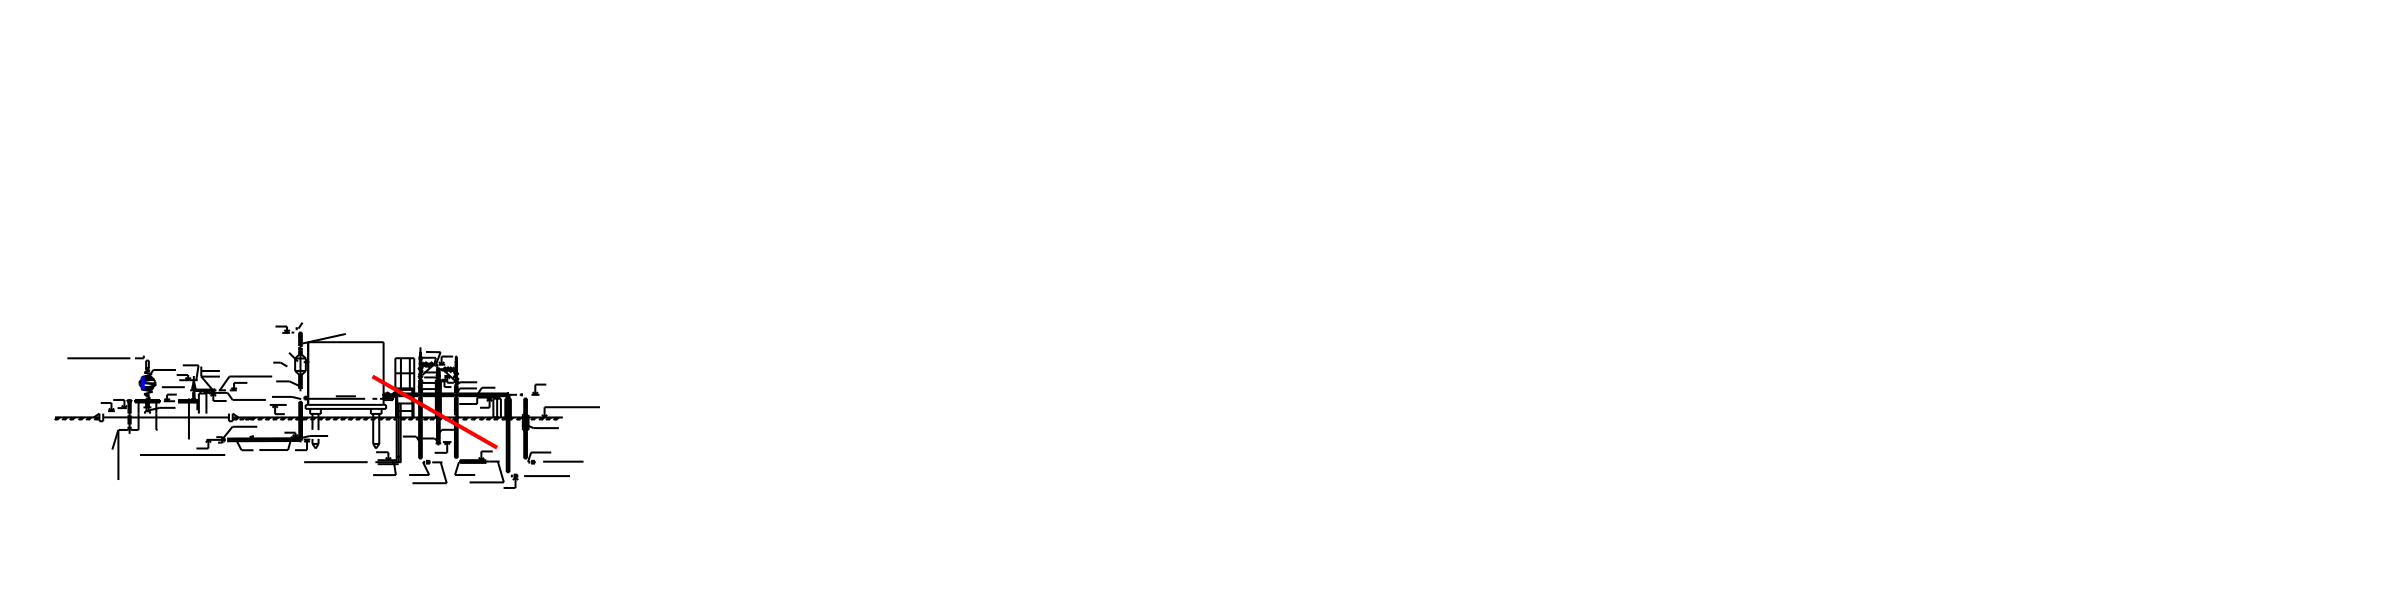

tensor([0.1141, 0.0492, 0.0214, 0.0487], grad_fn=<SelectBackward>)
entities: 42


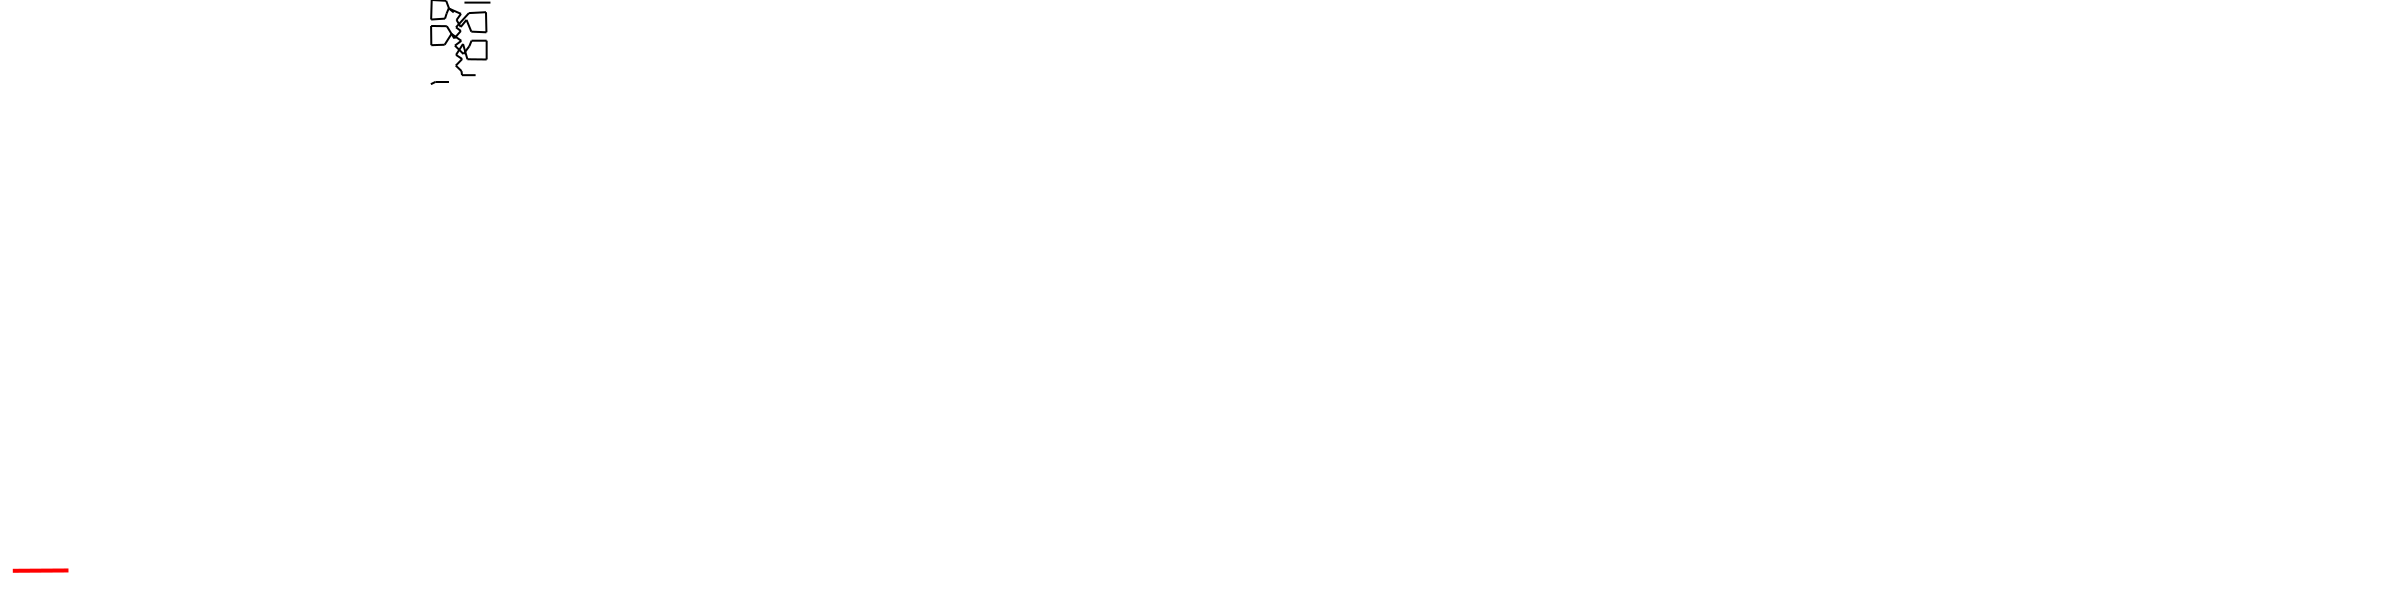

tensor([0.6806, 0.5698, 0.6916, 0.5729], grad_fn=<SelectBackward>)
entities: 12


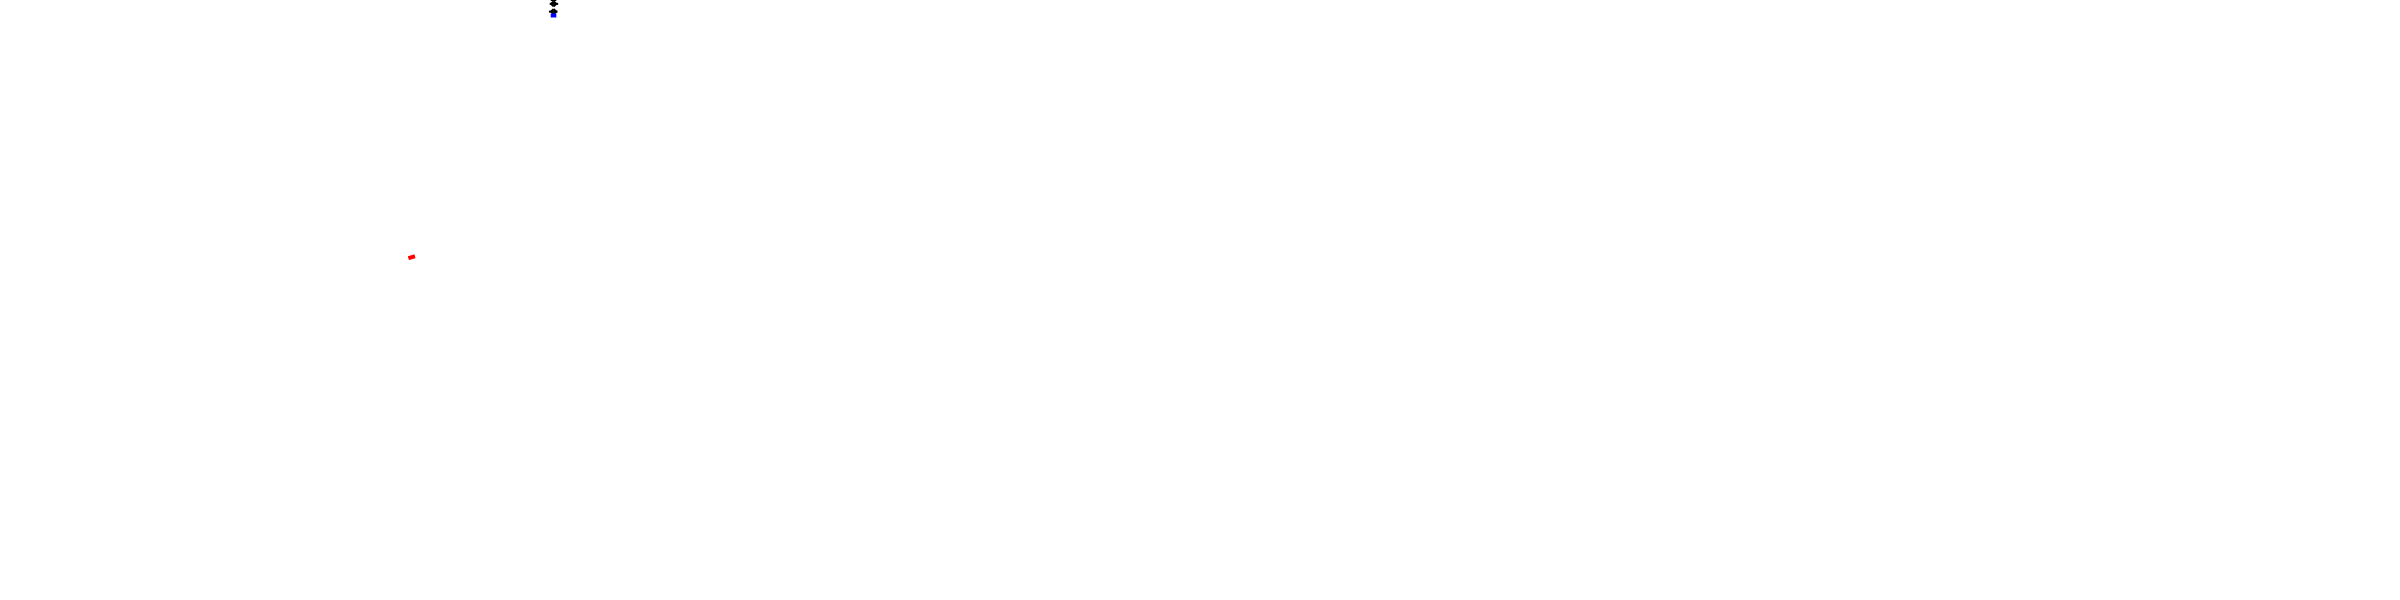

tensor([0.7044, 0.7801, 0.5109, 0.8064], grad_fn=<SelectBackward>)
entities: 89


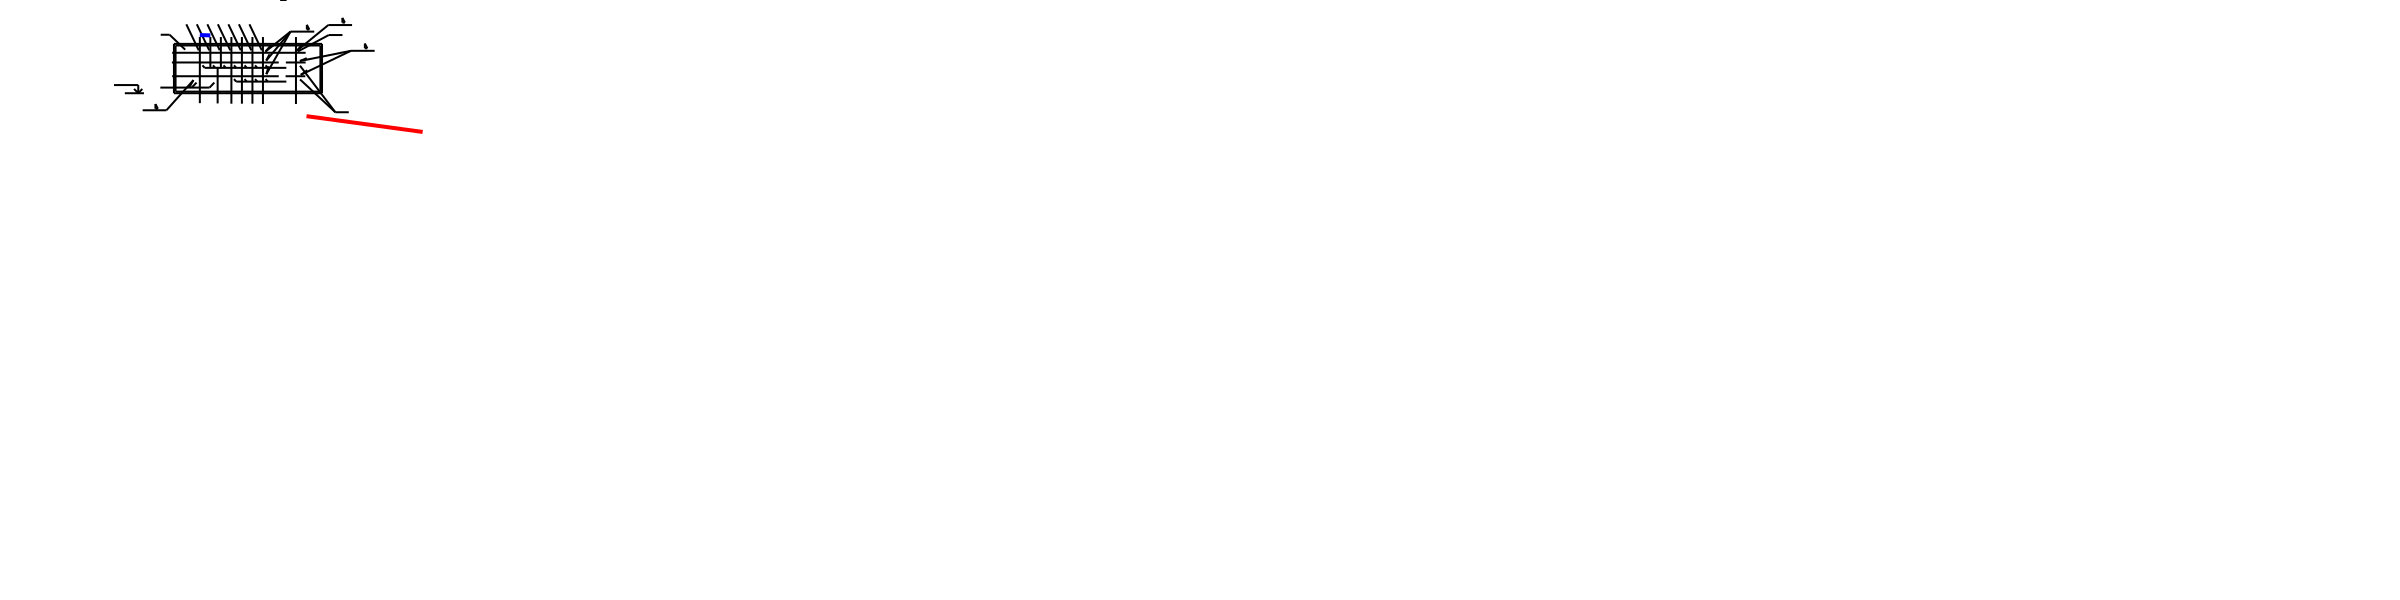

tensor([0.6410, 0.3919, 0.7971, 0.3870], grad_fn=<SelectBackward>)
entities: 59


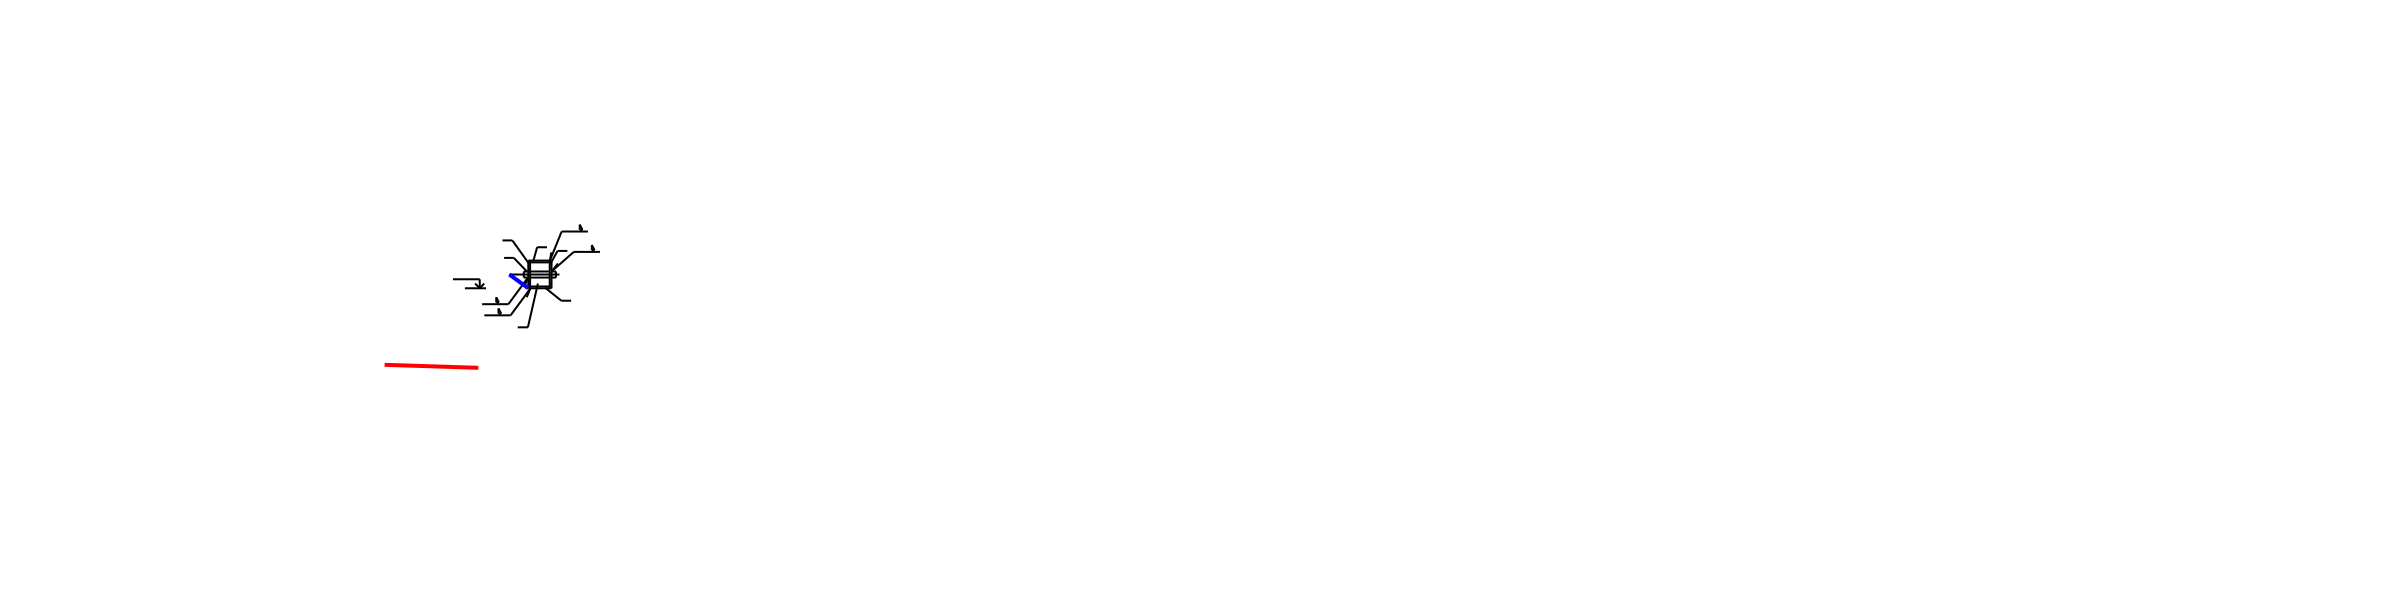

In [5]:
from IPython.display import Image
from IPython.display import clear_output

for j, (_x,_y) in enumerate(dwg_dataset.train_loader):
    _p = model(_x,_y)
    
    for i in range(len(_x)):
        x=_x[i]
        y=_y[i]
        p=_p[i]
        
        print(p)
        graphics = draw_sample(x,y,p, verbose=False)
        display(graphics) 
        #clear_output(wait=True)   
    if j>10:
        break